In [1]:
# Core libraries
import os
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Hugging Face libraries for Vision Transformer
from transformers import AutoModelForImageClassification, AutoFeatureExtractor
from tqdm import tqdm

# Ensure GPU is used if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


C:\Users\Muhammad Umar\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [2]:
import os
from sklearn.model_selection import train_test_split
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Define the custom dataset for labeled and unlabeled data
class SpectrogramDataset(Dataset):
    def __init__(self, image_paths, labels=None, transform=None, labeled=True):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.labeled = labeled

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        if self.labeled:
            label = self.labels[idx]
            return image, label
        else:
            return image

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for ViT
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Path to your dataset
data_dir = r"E:\1 Paper MCT\Cutting Tool Paper\Dataset\cutting tool data\test_data_40_images"

# Collect all image paths and corresponding labels
all_image_paths = []
all_labels = []
class_to_idx = {class_name: idx for idx, class_name in enumerate(os.listdir(data_dir))}

for class_name, label in class_to_idx.items():
    class_folder = os.path.join(data_dir, class_name)
    for file_name in os.listdir(class_folder):
        all_image_paths.append(os.path.join(class_folder, file_name))
        all_labels.append(label)

# Split into labeled and unlabeled data
labeled_paths, unlabeled_paths, labeled_labels, _ = train_test_split(
    all_image_paths, all_labels, test_size=0.7, stratify=all_labels, random_state=42
)

# Create datasets
labeled_dataset = SpectrogramDataset(labeled_paths, labeled_labels, transform=transform, labeled=True)
unlabeled_dataset = SpectrogramDataset(unlabeled_paths, transform=transform, labeled=False)

# Create data loaders
batch_size = 16
labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=False)

# Print statistics
print(f"Total images: {len(all_image_paths)}")
print(f"Labeled images: {len(labeled_dataset)}")
print(f"Unlabeled images: {len(unlabeled_dataset)}")


Total images: 280
Labeled images: 84
Unlabeled images: 196


In [3]:
from transformers import ViTForImageClassification, AutoFeatureExtractor
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define the number of classes in your dataset
num_classes = len(set(labeled_labels))  # Assuming `labeled_labels` contains the labeled dataset labels

# Load a pre-trained Vision Transformer model
teacher_model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=num_classes
)
teacher_model = teacher_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(teacher_model.parameters(), lr=5e-5)

# Training loop
def train_teacher_model(model, dataloader, criterion, optimizer, device, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for images, labels in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images).logits
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Calculate metrics
            epoch_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)

        epoch_accuracy = correct_predictions / total_samples
        print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

# Train the teacher model
train_teacher_model(teacher_model, labeled_loader, criterion, optimizer, device, num_epochs=5)

# Save the trained model
teacher_model.save_pretrained("teacher_model_new")


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/5: 100%|██████████| 6/6 [00:25<00:00,  4.24s/it]


Epoch [1/5] - Loss: 11.3233, Accuracy: 0.2262


Epoch 2/5: 100%|██████████| 6/6 [00:22<00:00,  3.71s/it]


Epoch [2/5] - Loss: 10.0122, Accuracy: 0.4405


Epoch 3/5: 100%|██████████| 6/6 [00:22<00:00,  3.74s/it]


Epoch [3/5] - Loss: 8.9818, Accuracy: 0.5952


Epoch 4/5: 100%|██████████| 6/6 [00:21<00:00,  3.63s/it]


Epoch [4/5] - Loss: 8.1590, Accuracy: 0.7143


Epoch 5/5: 100%|██████████| 6/6 [00:22<00:00,  3.81s/it]


Epoch [5/5] - Loss: 7.0482, Accuracy: 0.8333


In [4]:
from sklearn.metrics import classification_report, confusion_matrix

teacher_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in labeled_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = teacher_model(images).logits
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Print metrics
print(classification_report(y_true, y_pred, target_names=list(class_to_idx.keys())))
print(confusion_matrix(y_true, y_pred))


              precision    recall  f1-score   support

          BF       1.00      1.00      1.00        12
         BFI       1.00      1.00      1.00        12
          GF       1.00      1.00      1.00        12
         GFI       1.00      1.00      1.00        12
           N       0.67      1.00      0.80        12
          NI       1.00      0.92      0.96        12
          TF       1.00      0.58      0.74        12

    accuracy                           0.93        84
   macro avg       0.95      0.93      0.93        84
weighted avg       0.95      0.93      0.93        84

[[12  0  0  0  0  0  0]
 [ 0 12  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  1 11  0]
 [ 0  0  0  0  5  0  7]]


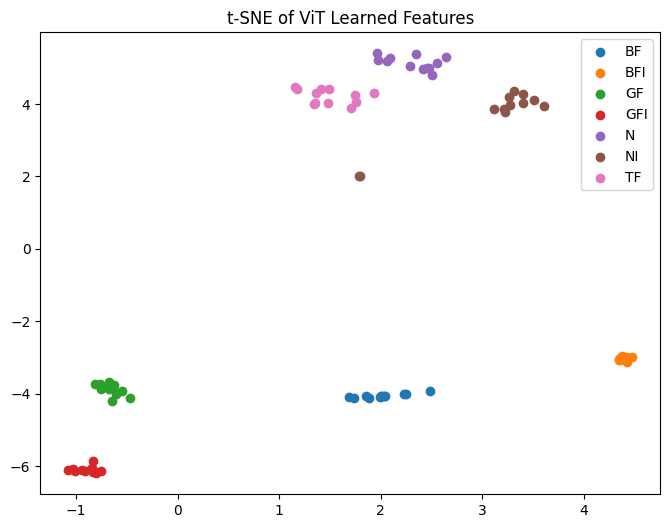

In [5]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

features = []
labels = []

teacher_model.eval()
with torch.no_grad():
    for images, lbls in labeled_loader:
        images = images.to(device)
        output = teacher_model.vit(images).last_hidden_state[:, 0, :]  # CLS token
        features.append(output.cpu())
        labels.extend(lbls)

features = torch.cat(features).numpy()
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(features)

plt.figure(figsize=(8, 6))
for label in np.unique(labels):
    idxs = np.array(labels) == label
    plt.scatter(tsne_result[idxs, 0], tsne_result[idxs, 1], label=list(class_to_idx.keys())[label])
plt.legend()
plt.title("t-SNE of ViT Learned Features")
plt.show()


In [6]:
from tqdm import tqdm
import torch

# Function to generate pseudo-labels
def generate_pseudo_labels(model, dataloader, device, confidence_threshold=0.9):
    model.eval()  # Set the model to evaluation mode
    pseudo_images = []
    pseudo_labels = []

    with torch.no_grad():  # Disable gradient computation
        for images in tqdm(dataloader, desc="Generating Pseudo-Labels"):
            images = images.to(device)
            outputs = model(images).logits  # Get the logits
            probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
            confidences, predicted_labels = torch.max(probs, dim=1)  # Get max confidence and corresponding labels

            # Filter predictions based on confidence threshold
            for i in range(len(confidences)):
                if confidences[i] >= confidence_threshold:
                    pseudo_images.append(images[i].cpu())
                    pseudo_labels.append(predicted_labels[i].cpu())

    return pseudo_images, pseudo_labels

# Generate pseudo-labels using the teacher model
confidence_threshold = 0.3  # Adjust as needed
pseudo_images, pseudo_labels = generate_pseudo_labels(teacher_model, unlabeled_loader, device, confidence_threshold)

# Check how many pseudo-labels were generated
print(f"Generated {len(pseudo_labels)} pseudo-labeled images from unlabeled data.")


Generating Pseudo-Labels: 100%|██████████| 13/13 [00:18<00:00,  1.40s/it]

Generated 142 pseudo-labeled images from unlabeled data.


In [7]:
from torch.utils.data import ConcatDataset

# Custom Dataset for the combined dataset
class CombinedDataset(Dataset):
    def __init__(self, labeled_dataset, pseudo_images, pseudo_labels, transform=None):
        self.labeled_dataset = labeled_dataset
        self.pseudo_images = pseudo_images
        self.pseudo_labels = pseudo_labels
        self.transform = transform

    def __len__(self):
        return len(self.labeled_dataset) + len(self.pseudo_images)

    def __getitem__(self, idx):
        if idx < len(self.labeled_dataset):
            image, label = self.labeled_dataset[idx]
            if self.transform and not isinstance(image, torch.Tensor):
                image = self.transform(image)
        else:
            pseudo_idx = idx - len(self.labeled_dataset)
            image = self.pseudo_images[pseudo_idx]
            label = self.pseudo_labels[pseudo_idx]

        # Convert label to tensor
        label = torch.tensor(label, dtype=torch.long)
        return image, label



# Create the combined dataset
combined_dataset = CombinedDataset(labeled_dataset, pseudo_images, pseudo_labels, transform=transform)

# Create a DataLoader for the combined dataset
combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

# Check the size of the combined dataset
print(f"Combined dataset size: {len(combined_dataset)}")


Combined dataset size: 226


In [8]:
from tqdm import tqdm

# Function to train the student model
def train_student_model(model, dataloader, criterion, optimizer, device, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        correct_predictions = 0
        total_samples = 0
        
        for images, labels in tqdm(dataloader, desc=f"Student Model Training Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Compute accuracy
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)
        
        epoch_loss /= len(dataloader)
        epoch_accuracy = correct_predictions / total_samples
        
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

# Initialize the student model
student_model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k", num_labels=len(class_to_idx)
).to(device)

# Define loss and optimizer
student_criterion = torch.nn.CrossEntropyLoss()
student_optimizer = torch.optim.AdamW(student_model.parameters(), lr=1e-4)

# Train the student model
train_student_model(student_model, combined_loader, student_criterion, student_optimizer, device, num_epochs=10)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Student Model Training Epoch 1/10:   0%|          | 0/15 [00:00<?, ?it/s]C:\Users\Muhammad Umar\AppData\Local\Temp\ipykernel_17760\3968711761.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long)
Student Model Training Epoch 1/10: 100%|██████████| 15/15 [01:04<00:00,  4.28s/it]


Epoch [1/10] - Loss: 1.6609, Accuracy: 0.4027


Student Model Training Epoch 2/10: 100%|██████████| 15/15 [01:11<00:00,  4.75s/it]


Epoch [2/10] - Loss: 1.0161, Accuracy: 0.8097


Student Model Training Epoch 3/10: 100%|██████████| 15/15 [01:05<00:00,  4.37s/it]


Epoch [3/10] - Loss: 0.5371, Accuracy: 0.9159


Student Model Training Epoch 4/10: 100%|██████████| 15/15 [01:00<00:00,  4.03s/it]


Epoch [4/10] - Loss: 0.3250, Accuracy: 0.9735


Student Model Training Epoch 5/10: 100%|██████████| 15/15 [00:58<00:00,  3.92s/it]


Epoch [5/10] - Loss: 0.1963, Accuracy: 1.0000


Student Model Training Epoch 6/10: 100%|██████████| 15/15 [00:59<00:00,  3.96s/it]


Epoch [6/10] - Loss: 0.1408, Accuracy: 1.0000


Student Model Training Epoch 7/10: 100%|██████████| 15/15 [01:00<00:00,  4.06s/it]


Epoch [7/10] - Loss: 0.1140, Accuracy: 1.0000


Student Model Training Epoch 8/10: 100%|██████████| 15/15 [01:07<00:00,  4.48s/it]


Epoch [8/10] - Loss: 0.0977, Accuracy: 1.0000


Student Model Training Epoch 9/10: 100%|██████████| 15/15 [01:01<00:00,  4.07s/it]


Epoch [9/10] - Loss: 0.0863, Accuracy: 1.0000


Student Model Training Epoch 10/10: 100%|██████████| 15/15 [00:57<00:00,  3.82s/it]

Epoch [10/10] - Loss: 0.0777, Accuracy: 1.0000


In [9]:
for images, labels in combined_loader:
    print(f"Image batch type: {type(images)}, Label batch type: {type(labels)}")
    print(f"First image shape: {images[0].shape}, First label: {labels[0]}")
    break


Image batch type: <class 'torch.Tensor'>, Label batch type: <class 'torch.Tensor'>
First image shape: torch.Size([3, 224, 224]), First label: 0


C:\Users\Muhammad Umar\AppData\Local\Temp\ipykernel_17760\3968711761.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long)


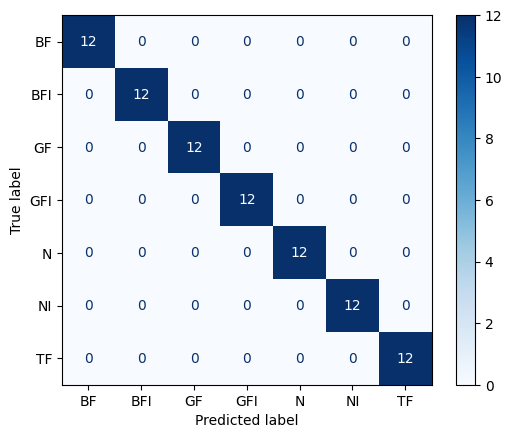

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Evaluate on test dataset
test_preds, test_labels = evaluate_model(student_model, labeled_loader, device)

# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(class_to_idx.keys()))
disp.plot(cmap="Blues")
#plt.title("Confusion Matrix")
plt.show()


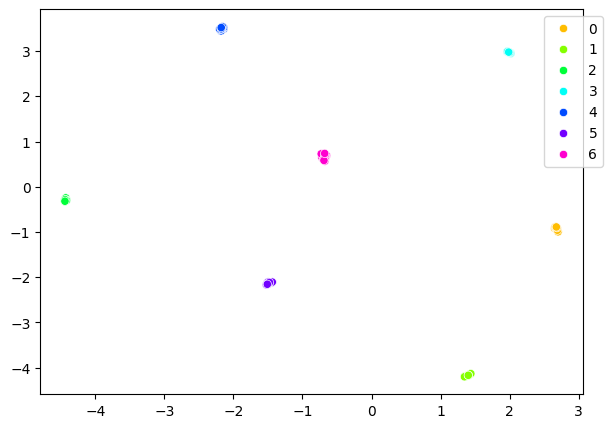

In [11]:
from sklearn.manifold import TSNE
import seaborn as sns

def extract_features(model, dataloader, device):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, batch_labels in dataloader:
            images = images.to(device)
            outputs = model(images).logits
            features.extend(outputs.cpu().numpy())
            labels.extend(batch_labels.numpy())
    return np.array(features), np.array(labels)

# Extract features
features, labels = extract_features(student_model, labeled_loader, device)

# Apply T-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(features)

# Plot the T-SNE
plt.figure(figsize=(7, 5))
sns.scatterplot(
    x=tsne_results[:, 0], 
    y=tsne_results[:, 1], 
    hue=labels, 
    palette=sns.color_palette("hsv", len(class_to_idx)),
    legend="full"
)

plt.legend(loc='best', bbox_to_anchor=(1.05, 1))
plt.show()


C:\Users\Muhammad Umar\AppData\Roaming\Python\Python313\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


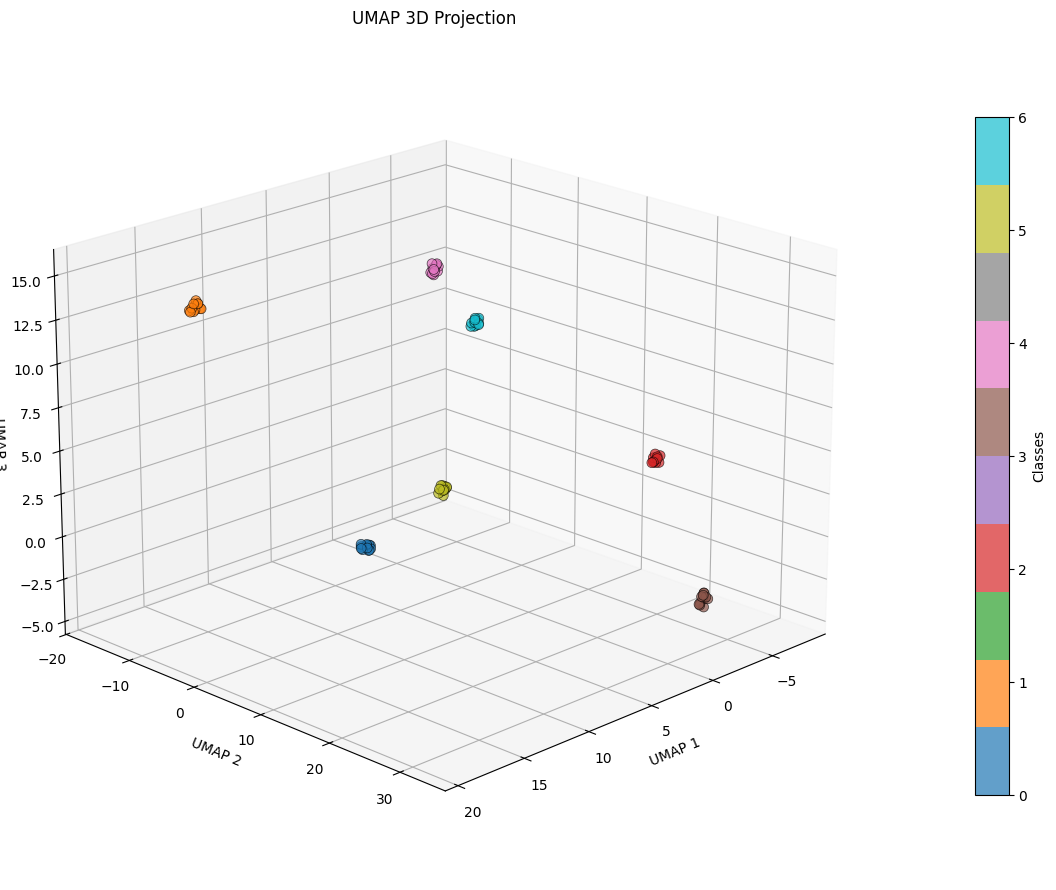

In [18]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

# UMAP reduction
umap_model = umap.UMAP(n_components=3, random_state=42, n_neighbors=15, min_dist=0.1)
umap_results = umap_model.fit_transform(features)

# 3D plot with enhancements
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    umap_results[:, 0], 
    umap_results[:, 1], 
    umap_results[:, 2], 
    c=labels, 
    cmap='tab10',
    alpha=0.7,
    s=50,
    edgecolors='black',
    linewidth=0.5
)

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')
ax.set_title('UMAP 3D Projection')

plt.colorbar(scatter, label="Classes", shrink=0.8, pad=0.1)
ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

In [19]:
from sklearn.metrics import classification_report

def print_classification_report(model, dataloader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs.logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Generate classification report
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("Classification Report:")
    print(report)

# Replace `class_names` with the list of your class names
class_names = ['BF', 'BFI', 'GF', 'GFI', 'N', 'NI', 'TF']  # Adjust according to your dataset

# Call the function to print the report
print_classification_report(student_model, labeled_loader, device, class_names)


Classification Report:
              precision    recall  f1-score   support

          BF       1.00      1.00      1.00        12
         BFI       1.00      1.00      1.00        12
          GF       1.00      1.00      1.00        12
         GFI       1.00      1.00      1.00        12
           N       1.00      1.00      1.00        12
          NI       1.00      1.00      1.00        12
          TF       1.00      1.00      1.00        12

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84



In [20]:
import random, time, copy, math
from collections import defaultdict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import ViTForImageClassification

# ---- Reuse your device, transform, SpectrogramDataset, class_to_idx, all_image_paths, all_labels ----
# device, transform, SpectrogramDataset, class_to_idx, all_image_paths, all_labels should already exist

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

def expected_calibration_error(probs, labels, n_bins=15):
    """Compute ECE for multi-class (uses max prob)."""
    confidences = probs.max(axis=1)
    predictions = probs.argmax(axis=1)
    accuracies = (predictions == labels).astype(float)
    bins = np.linspace(0.0, 1.0, n_bins+1)
    ece = 0.0
    bin_accs, bin_confs, bin_fracs = [], [], []
    for i in range(n_bins):
        in_bin = (confidences > bins[i]) & (confidences <= bins[i+1] if i < n_bins-1 else confidences <= bins[i+1])
        if in_bin.any():
            bin_frac = in_bin.mean()
            bin_conf = confidences[in_bin].mean()
            bin_acc = accuracies[in_bin].mean()
            ece += np.abs(bin_acc - bin_conf) * bin_frac
            bin_accs.append(bin_acc); bin_confs.append(bin_conf); bin_fracs.append(bin_frac)
        else:
            bin_accs.append(0.0); bin_confs.append(0.0); bin_fracs.append(0.0)
    return ece, bins, np.array(bin_accs), np.array(bin_confs), np.array(bin_fracs)

def plot_reliability_diagram(bins, bin_accs, bin_confs, title="Reliability Diagram"):
    mids = (bins[:-1] + bins[1:]) / 2
    plt.figure(figsize=(5.5,5.5))
    plt.plot([0,1],[0,1], linestyle='--')
    plt.bar(mids, bin_accs, width=(bins[1]-bins[0])*0.9, alpha=0.6, label='Accuracy per bin')
    plt.plot(mids, bin_confs, marker='o', linewidth=1.5, label='Confidence per bin')
    plt.xlabel('Confidence'); plt.ylabel('Accuracy'); plt.title(title); plt.legend(); plt.tight_layout(); plt.show()

def make_model(num_classes):
    model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=num_classes)
    return model.to(device)

def train_one_split(model, train_loader, val_loader, epochs=10, lr=5e-5, wd=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

    for epoch in range(epochs):
        # ----- Train -----
        model.train()
        tloss, tcorrect, tcount = 0.0, 0, 0
        for x,y in train_loader:
            x,y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x).logits
            loss = criterion(logits, y)
            loss.backward(); optimizer.step()
            tloss += loss.item() * y.size(0)
            tcorrect += (logits.argmax(1)==y).sum().item()
            tcount += y.size(0)

        # ----- Val -----
        model.eval()
        vloss, vcorrect, vcount = 0.0, 0, 0
        with torch.no_grad():
            for x,y in val_loader:
                x,y = x.to(device), y.to(device)
                logits = model(x).logits
                loss = criterion(logits, y)
                vloss += loss.item() * y.size(0)
                vcorrect += (logits.argmax(1)==y).sum().item()
                vcount += y.size(0)

        history['train_loss'].append(tloss/tcount)
        history['train_acc'].append(tcorrect/tcount)
        history['val_loss'].append(vloss/vcount)
        history['val_acc'].append(vcorrect/vcount)
        print(f"Epoch {epoch+1}/{epochs} | train_acc={history['train_acc'][-1]:.4f} val_acc={history['val_acc'][-1]:.4f}")

    return history



========== Fold 1/5 ==========
Train class counts: {'BF': 32, 'BFI': 32, 'GF': 32, 'GFI': 32, 'N': 32, 'NI': 32, 'TF': 32}
Val   class counts: {'BF': 8, 'BFI': 8, 'GF': 8, 'GFI': 8, 'N': 8, 'NI': 8, 'TF': 8}


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 | train_acc=0.3616 val_acc=0.7321
Epoch 2/10 | train_acc=0.8170 val_acc=1.0000
Epoch 3/10 | train_acc=1.0000 val_acc=1.0000
Epoch 4/10 | train_acc=1.0000 val_acc=1.0000
Epoch 5/10 | train_acc=1.0000 val_acc=1.0000
Epoch 6/10 | train_acc=1.0000 val_acc=1.0000
Epoch 7/10 | train_acc=1.0000 val_acc=1.0000
Epoch 8/10 | train_acc=1.0000 val_acc=1.0000
Epoch 9/10 | train_acc=1.0000 val_acc=1.0000
Epoch 10/10 | train_acc=1.0000 val_acc=1.0000


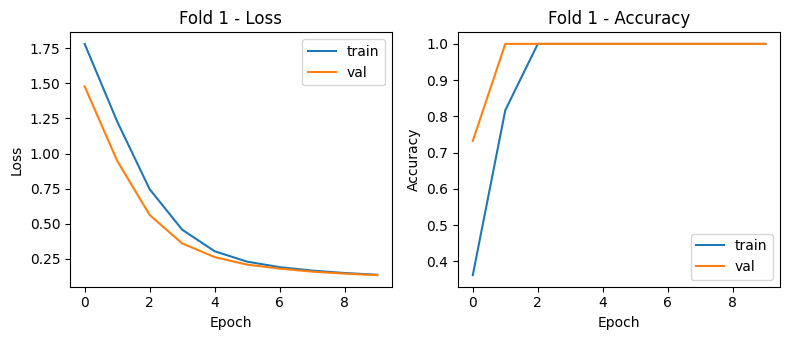

Fold 1 accuracy: 1.0000
              precision    recall  f1-score   support

          BF       1.00      1.00      1.00         8
         BFI       1.00      1.00      1.00         8
          GF       1.00      1.00      1.00         8
         GFI       1.00      1.00      1.00         8
           N       1.00      1.00      1.00         8
          NI       1.00      1.00      1.00         8
          TF       1.00      1.00      1.00         8

    accuracy                           1.00        56
   macro avg       1.00      1.00      1.00        56
weighted avg       1.00      1.00      1.00        56

Fold 1 ECE: 0.1233


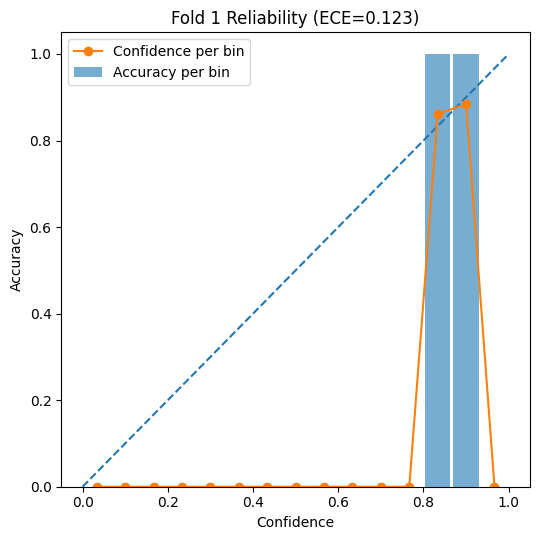

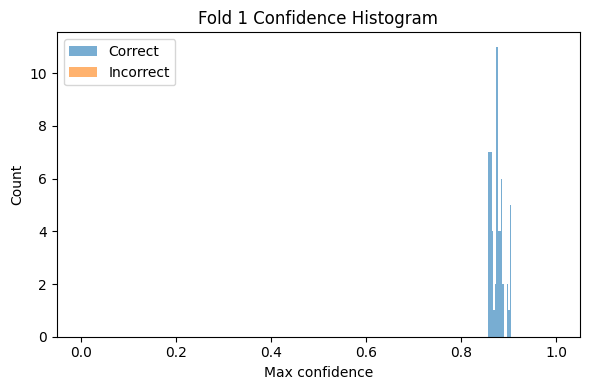


========== Fold 2/5 ==========
Train class counts: {'BF': 32, 'BFI': 32, 'GF': 32, 'GFI': 32, 'N': 32, 'NI': 32, 'TF': 32}
Val   class counts: {'BF': 8, 'BFI': 8, 'GF': 8, 'GFI': 8, 'N': 8, 'NI': 8, 'TF': 8}


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 | train_acc=0.2321 val_acc=0.5000
Epoch 2/10 | train_acc=0.6384 val_acc=0.8750
Epoch 3/10 | train_acc=0.9107 val_acc=1.0000
Epoch 4/10 | train_acc=1.0000 val_acc=1.0000
Epoch 5/10 | train_acc=1.0000 val_acc=1.0000
Epoch 6/10 | train_acc=1.0000 val_acc=1.0000
Epoch 7/10 | train_acc=1.0000 val_acc=1.0000
Epoch 8/10 | train_acc=1.0000 val_acc=1.0000
Epoch 9/10 | train_acc=1.0000 val_acc=1.0000
Epoch 10/10 | train_acc=1.0000 val_acc=1.0000


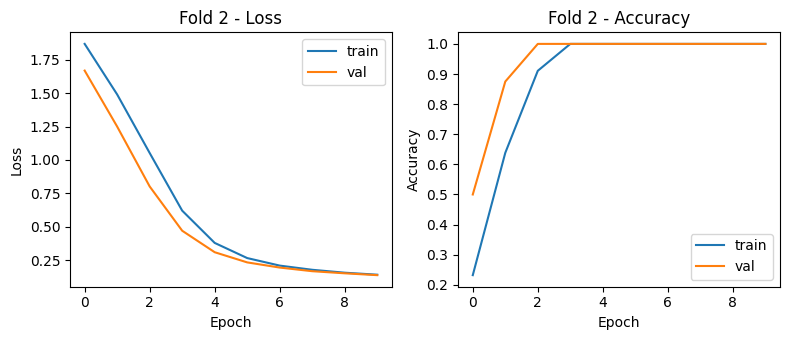

Fold 2 accuracy: 1.0000
              precision    recall  f1-score   support

          BF       1.00      1.00      1.00         8
         BFI       1.00      1.00      1.00         8
          GF       1.00      1.00      1.00         8
         GFI       1.00      1.00      1.00         8
           N       1.00      1.00      1.00         8
          NI       1.00      1.00      1.00         8
          TF       1.00      1.00      1.00         8

    accuracy                           1.00        56
   macro avg       1.00      1.00      1.00        56
weighted avg       1.00      1.00      1.00        56

Fold 2 ECE: 0.1289


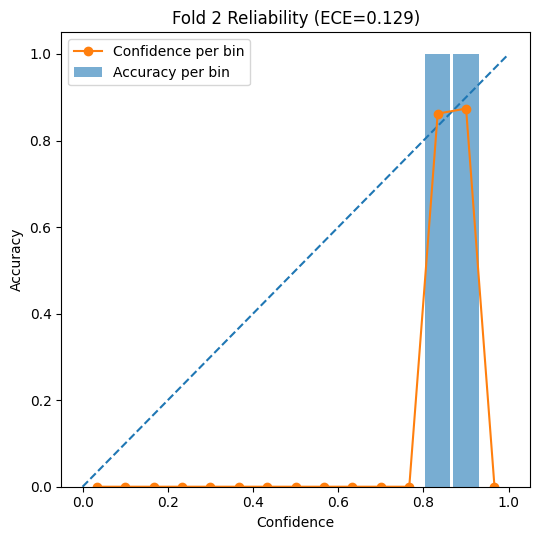

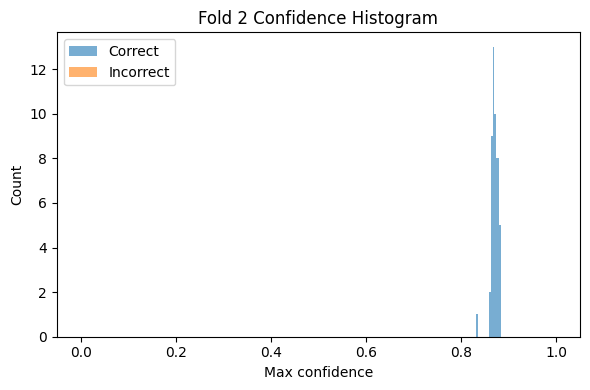


========== Fold 3/5 ==========
Train class counts: {'BF': 32, 'BFI': 32, 'GF': 32, 'GFI': 32, 'N': 32, 'NI': 32, 'TF': 32}
Val   class counts: {'BF': 8, 'BFI': 8, 'GF': 8, 'GFI': 8, 'N': 8, 'NI': 8, 'TF': 8}


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 | train_acc=0.3036 val_acc=0.7679
Epoch 2/10 | train_acc=0.7634 val_acc=0.9643
Epoch 3/10 | train_acc=0.9732 val_acc=1.0000
Epoch 4/10 | train_acc=1.0000 val_acc=1.0000
Epoch 5/10 | train_acc=1.0000 val_acc=1.0000
Epoch 6/10 | train_acc=1.0000 val_acc=1.0000
Epoch 7/10 | train_acc=1.0000 val_acc=1.0000
Epoch 8/10 | train_acc=1.0000 val_acc=1.0000
Epoch 9/10 | train_acc=1.0000 val_acc=1.0000
Epoch 10/10 | train_acc=1.0000 val_acc=1.0000


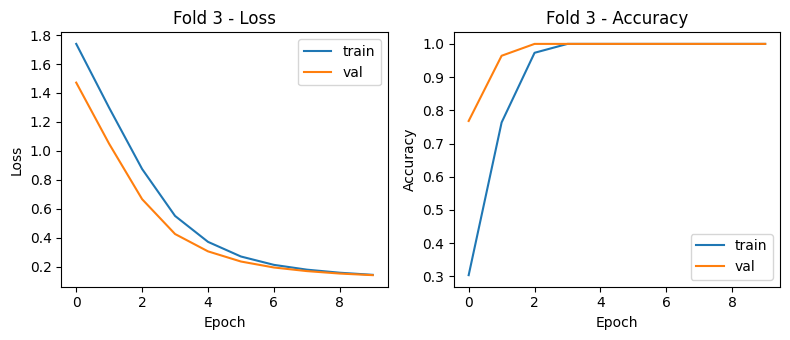

Fold 3 accuracy: 1.0000
              precision    recall  f1-score   support

          BF       1.00      1.00      1.00         8
         BFI       1.00      1.00      1.00         8
          GF       1.00      1.00      1.00         8
         GFI       1.00      1.00      1.00         8
           N       1.00      1.00      1.00         8
          NI       1.00      1.00      1.00         8
          TF       1.00      1.00      1.00         8

    accuracy                           1.00        56
   macro avg       1.00      1.00      1.00        56
weighted avg       1.00      1.00      1.00        56

Fold 3 ECE: 0.1315


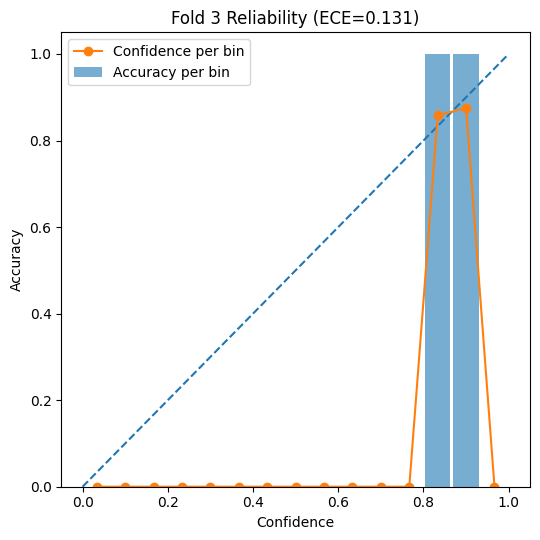

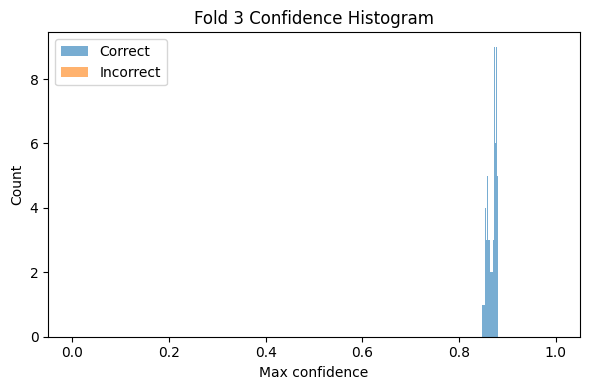


========== Fold 4/5 ==========
Train class counts: {'BF': 32, 'BFI': 32, 'GF': 32, 'GFI': 32, 'N': 32, 'NI': 32, 'TF': 32}
Val   class counts: {'BF': 8, 'BFI': 8, 'GF': 8, 'GFI': 8, 'N': 8, 'NI': 8, 'TF': 8}


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 | train_acc=0.4286 val_acc=0.6071
Epoch 2/10 | train_acc=0.7545 val_acc=0.9643
Epoch 3/10 | train_acc=0.9955 val_acc=0.9821
Epoch 4/10 | train_acc=1.0000 val_acc=1.0000
Epoch 5/10 | train_acc=1.0000 val_acc=1.0000
Epoch 6/10 | train_acc=1.0000 val_acc=1.0000
Epoch 7/10 | train_acc=1.0000 val_acc=1.0000
Epoch 8/10 | train_acc=1.0000 val_acc=1.0000
Epoch 9/10 | train_acc=1.0000 val_acc=1.0000
Epoch 10/10 | train_acc=1.0000 val_acc=1.0000


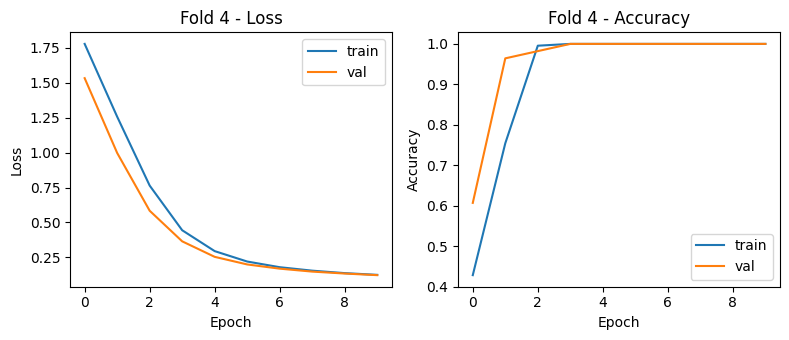

Fold 4 accuracy: 1.0000
              precision    recall  f1-score   support

          BF       1.00      1.00      1.00         8
         BFI       1.00      1.00      1.00         8
          GF       1.00      1.00      1.00         8
         GFI       1.00      1.00      1.00         8
           N       1.00      1.00      1.00         8
          NI       1.00      1.00      1.00         8
          TF       1.00      1.00      1.00         8

    accuracy                           1.00        56
   macro avg       1.00      1.00      1.00        56
weighted avg       1.00      1.00      1.00        56

Fold 4 ECE: 0.1159


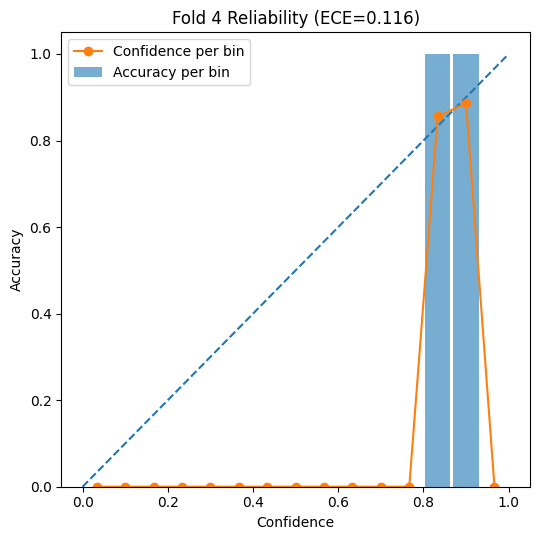

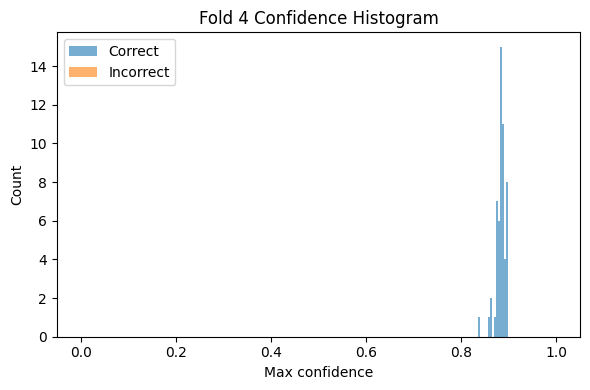


========== Fold 5/5 ==========
Train class counts: {'BF': 32, 'BFI': 32, 'GF': 32, 'GFI': 32, 'N': 32, 'NI': 32, 'TF': 32}
Val   class counts: {'BF': 8, 'BFI': 8, 'GF': 8, 'GFI': 8, 'N': 8, 'NI': 8, 'TF': 8}


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 | train_acc=0.2411 val_acc=0.4821
Epoch 2/10 | train_acc=0.6384 val_acc=0.9286
Epoch 3/10 | train_acc=0.9688 val_acc=0.9107
Epoch 4/10 | train_acc=0.9911 val_acc=1.0000
Epoch 5/10 | train_acc=1.0000 val_acc=1.0000
Epoch 6/10 | train_acc=1.0000 val_acc=1.0000
Epoch 7/10 | train_acc=1.0000 val_acc=1.0000
Epoch 8/10 | train_acc=1.0000 val_acc=1.0000
Epoch 9/10 | train_acc=1.0000 val_acc=1.0000
Epoch 10/10 | train_acc=1.0000 val_acc=1.0000


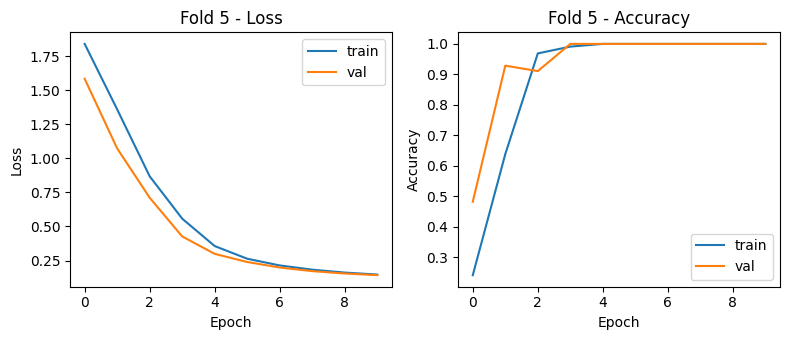

Fold 5 accuracy: 1.0000
              precision    recall  f1-score   support

          BF       1.00      1.00      1.00         8
         BFI       1.00      1.00      1.00         8
          GF       1.00      1.00      1.00         8
         GFI       1.00      1.00      1.00         8
           N       1.00      1.00      1.00         8
          NI       1.00      1.00      1.00         8
          TF       1.00      1.00      1.00         8

    accuracy                           1.00        56
   macro avg       1.00      1.00      1.00        56
weighted avg       1.00      1.00      1.00        56

Fold 5 ECE: 0.1326


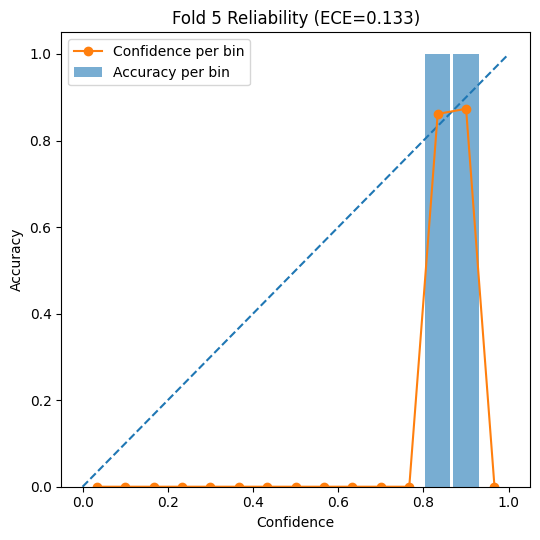

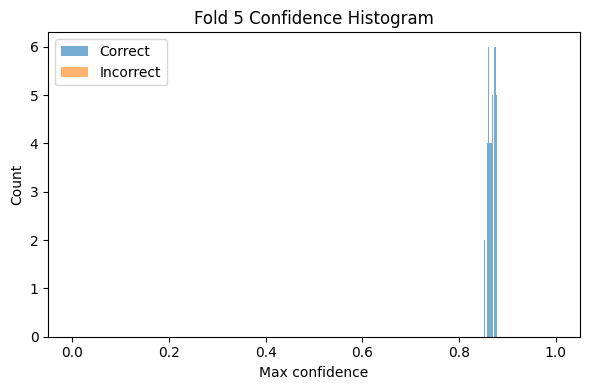

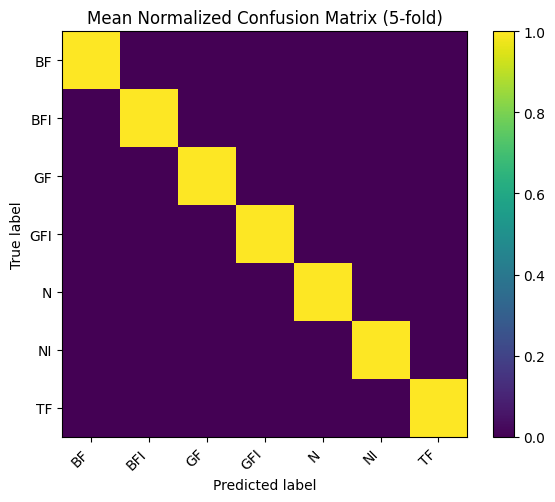


Cross-validated accuracy: mean=1.0000  std=0.0000


In [21]:
set_seed(42)

num_classes = len(class_to_idx)
class_names = list(class_to_idx.keys())
indices = np.arange(len(all_image_paths))
labels_np = np.array(all_labels)

# CV config
k = 5
batch_size = 16
epochs = 10
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# storage
fold_reports = []
fold_accs = []
mean_conf = np.zeros((num_classes, num_classes), dtype=np.float64)

for fold, (train_idx, val_idx) in enumerate(kf.split(indices, labels_np), 1):
    print(f"\n========== Fold {fold}/{k} ==========")
    train_paths = [all_image_paths[i] for i in train_idx]
    train_labels = [all_labels[i] for i in train_idx]
    val_paths   = [all_image_paths[i] for i in val_idx]
    val_labels  = [all_labels[i] for i in val_idx]

    # sanity check on stratification
    print("Train class counts:", {class_names[c]: int((np.array(train_labels)==c).sum()) for c in range(num_classes)})
    print("Val   class counts:", {class_names[c]: int((np.array(val_labels)==c).sum()) for c in range(num_classes)})

    train_ds = SpectrogramDataset(train_paths, train_labels, transform=transform, labeled=True)
    val_ds   = SpectrogramDataset(val_paths,   val_labels,   transform=transform, labeled=True)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0)

    model = make_model(num_classes)
    history = train_one_split(model, train_loader, val_loader, epochs=epochs, lr=5e-5, wd=0.01)

    # learning curves
    plt.figure(figsize=(8,3.5))
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], label='train'); plt.plot(history['val_loss'], label='val')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title(f'Fold {fold} - Loss'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history['train_acc'], label='train'); plt.plot(history['val_acc'], label='val')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title(f'Fold {fold} - Accuracy'); plt.legend()
    plt.tight_layout(); plt.show()

    # collect predictions for confusion matrix, calibration, report
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            logits = model(xb).logits
            prob = torch.softmax(logits, dim=1).cpu().numpy()
            pred = logits.argmax(1).cpu().numpy()
            y_prob.append(prob)
            y_pred.append(pred)
            y_true.append(yb.numpy())
    y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred); y_prob = np.concatenate(y_prob)

    # fold metrics
    acc = accuracy_score(y_true, y_pred); fold_accs.append(acc)
    print(f"Fold {fold} accuracy: {acc:.4f}")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # update averaged confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    mean_conf += cm

    # reliability diagram + ECE
    ece, bins, bin_accs, bin_confs, bin_fracs = expected_calibration_error(y_prob, y_true, n_bins=15)
    print(f"Fold {fold} ECE: {ece:.4f}")
    plot_reliability_diagram(bins, bin_accs, bin_confs, title=f"Fold {fold} Reliability (ECE={ece:.3f})")

    # confidence histogram & correctness
    max_conf = y_prob.max(axis=1)
    correct  = (y_pred == y_true).astype(int)
    plt.figure(figsize=(6,4))
    plt.hist(max_conf[correct==1], bins=15, alpha=0.6, label='Correct')
    plt.hist(max_conf[correct==0], bins=15, alpha=0.6, label='Incorrect')
    plt.xlabel('Max confidence'); plt.ylabel('Count'); plt.title(f'Fold {fold} Confidence Histogram'); plt.legend(); plt.tight_layout(); plt.show()

# average confusion matrix (over folds)
mean_conf = mean_conf / mean_conf.sum(axis=1, keepdims=True)  # normalize per true class
plt.figure(figsize=(6,5))
plt.imshow(mean_conf, interpolation='nearest')
plt.title('Mean Normalized Confusion Matrix (5-fold)'); plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45, ha='right'); plt.yticks(tick_marks, class_names)
plt.ylabel('True label'); plt.xlabel('Predicted label'); plt.tight_layout(); plt.show()

print(f"\nCross-validated accuracy: mean={np.mean(fold_accs):.4f}  std={np.std(fold_accs):.4f}")



========== Fold 1/5 ==========


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 1 accuracy: 1.0000

========== Fold 2/5 ==========


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 2 accuracy: 1.0000

========== Fold 3/5 ==========


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 3 accuracy: 1.0000

========== Fold 4/5 ==========


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 4 accuracy: 1.0000

========== Fold 5/5 ==========


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 5 accuracy: 1.0000


C:\Users\Muhammad Umar\AppData\Local\Temp\ipykernel_17760\1637793448.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


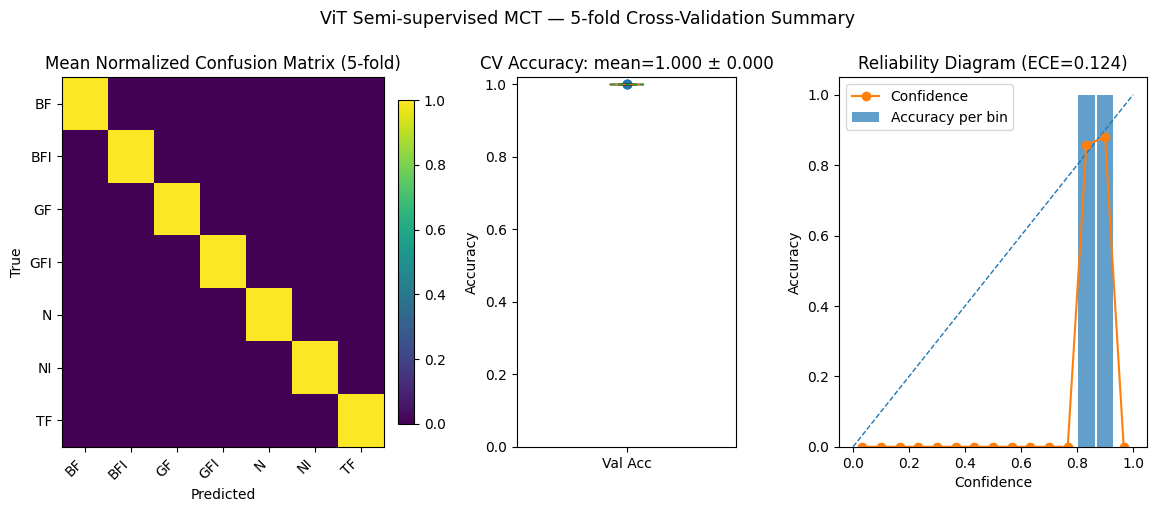

Saved: cv_summary.png | CV mean=1.0000, std=0.0000, ECE=0.1244


In [25]:
# === Single-Figure Cross-Validation Summary (drop-in) ===
# Reuses: device, SpectrogramDataset, transform, class_to_idx, all_image_paths, all_labels,
#         make_model, train_one_split, expected_calibration_error
import numpy as np, torch, matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score
from torch.utils.data import DataLoader
from matplotlib.gridspec import GridSpec

plt.close('all')

set_seed(42)

num_classes = len(class_to_idx)
class_names = list(class_to_idx.keys())
indices = np.arange(len(all_image_paths))
labels_np = np.array(all_labels)

k = 5
batch_size = 16
epochs = 10
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

fold_accs = []
mean_conf_counts = np.zeros((num_classes, num_classes), dtype=np.float64)
y_prob_all, y_true_all = [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(indices, labels_np), 1):
    print(f"\n========== Fold {fold}/{k} ==========")
    train_paths = [all_image_paths[i] for i in train_idx]
    train_labels = [all_labels[i] for i in train_idx]
    val_paths   = [all_image_paths[i] for i in val_idx]
    val_labels  = [all_labels[i] for i in val_idx]

    train_ds = SpectrogramDataset(train_paths, train_labels, transform=transform, labeled=True)
    val_ds   = SpectrogramDataset(val_paths,   val_labels,   transform=transform, labeled=True)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0)

    model = make_model(num_classes)
    _ = train_one_split(model, train_loader, val_loader, epochs=epochs, lr=5e-5, wd=0.01)

    # Validate and aggregate (no per-fold plots)
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            logits = model(xb).logits
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            preds = logits.argmax(1).cpu().numpy()
            y_prob_all.append(probs)
            y_true_all.append(yb.numpy())
            y_true.extend(yb.numpy())
            y_pred.extend(preds)

    y_true = np.array(y_true); y_pred = np.array(y_pred)
    acc = accuracy_score(y_true, y_pred)
    fold_accs.append(acc)
    print(f"Fold {fold} accuracy: {acc:.4f}")

    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    mean_conf_counts += cm

# ---- Aggregate for single figure ----
y_prob_all = np.concatenate(y_prob_all)
y_true_all = np.concatenate(y_true_all)

# Normalize confusion matrix by true row
row_sums = mean_conf_counts.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1.0
mean_conf = mean_conf_counts / row_sums

# Calibration (ECE)
ece, bins, bin_accs, bin_confs, _ = expected_calibration_error(y_prob_all, y_true_all, n_bins=15)
mids = (bins[:-1] + bins[1:]) / 2

# ---- ONE consolidated figure ----
fig = plt.figure(figsize=(14, 4.8))
gs = GridSpec(1, 3, width_ratios=[1.6, 1.0, 1.4], wspace=0.35)

# (A) Mean normalized confusion matrix
ax1 = fig.add_subplot(gs[0, 0])
im = ax1.imshow(mean_conf, interpolation='nearest', aspect='auto')
ax1.set_title('Mean Normalized Confusion Matrix (5-fold)')
ax1.set_xticks(range(num_classes)); ax1.set_xticklabels(class_names, rotation=45, ha='right')
ax1.set_yticks(range(num_classes)); ax1.set_yticklabels(class_names)
fig.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
ax1.set_xlabel('Predicted'); ax1.set_ylabel('True')

# (B) Per-fold accuracy (box + points)
ax2 = fig.add_subplot(gs[0, 1])
ax2.boxplot(fold_accs, showmeans=True, meanline=True)
ax2.scatter(np.ones(len(fold_accs)), fold_accs, alpha=0.7)
ax2.set_ylim(0.0, 1.02)
ax2.set_xticks([1]); ax2.set_xticklabels(['Val Acc'])
ax2.set_title(f'CV Accuracy: mean={np.mean(fold_accs):.3f} ± {np.std(fold_accs):.3f}')
ax2.set_ylabel('Accuracy')

# (C) Reliability diagram with ECE
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot([0,1],[0,1],'--', linewidth=1)
ax3.bar(mids, bin_accs, width=(bins[1]-bins[0])*0.9, alpha=0.7, label='Accuracy per bin')
ax3.plot(mids, bin_confs, marker='o', linewidth=1.5, label='Confidence')
ax3.set_xlabel('Confidence'); ax3.set_ylabel('Accuracy')
ax3.set_title(f'Reliability Diagram (ECE={ece:.3f})')
ax3.legend()

fig.suptitle('ViT Semi-supervised MCT — 5-fold Cross-Validation Summary', y=1.02, fontsize=12.5)
plt.tight_layout()
plt.savefig('cv_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Saved: cv_summary.png | CV mean={np.mean(fold_accs):.4f}, std={np.std(fold_accs):.4f}, ECE={ece:.4f}")


Saved: cv_confusion_matrix_annotated.png (Accuracy: 100.00%)


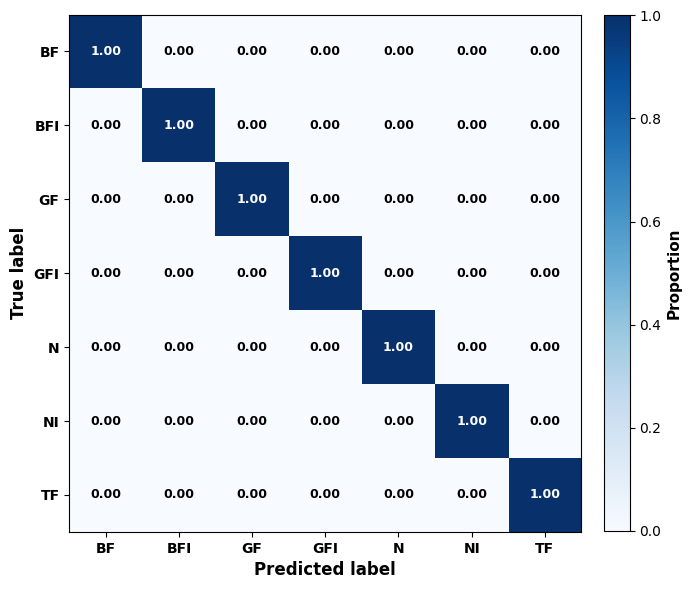

In [81]:
# === FIGURE 1: Enhanced Confusion Matrix (shows errors more clearly) ===
fig1, ax1 = plt.subplots(figsize=(7, 6))

# Use a colormap that makes small values more visible
im = ax1.imshow(mean_conf, interpolation='nearest', aspect='auto', 
                cmap='Blues', vmin=0, vmax=1.0)

ax1.set_xticks(range(num_classes))
ax1.set_xticklabels(class_names, fontweight="bold")
ax1.set_yticks(range(num_classes))
ax1.set_yticklabels(class_names, fontweight="bold")

# Add text annotations showing actual values
for i in range(num_classes):
    for j in range(num_classes):
        value = mean_conf[i, j]
        color = 'white' if value > 0.5 else 'black'
        ax1.text(j, i, f'{value:.2f}', 
                ha='center', va='center', 
                color=color, fontsize=9, fontweight='bold')

cbar = fig1.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
cbar.set_label('Proportion', fontweight='bold', fontsize=11)

ax1.set_xlabel('Predicted label', fontsize=12, fontweight="bold")
ax1.set_ylabel('True label', fontsize=12, fontweight="bold")

# Add accuracy info
overall_acc = np.trace(mean_conf) / num_classes

plt.tight_layout()
plt.savefig('cv_confusion_matrix_annotated.png', dpi=300, bbox_inches='tight')
print(f"Saved: cv_confusion_matrix_annotated.png (Accuracy: {overall_acc:.2%})")

Saved: cv_confusion_matrix.png


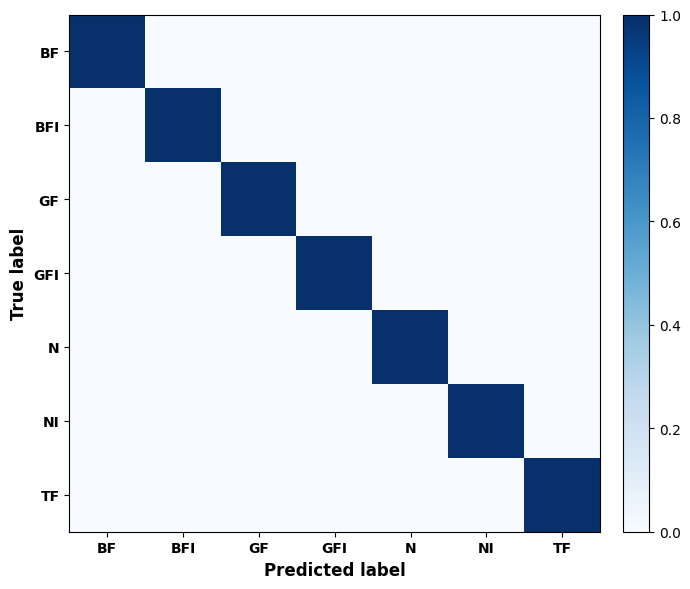

In [77]:
# === FIGURE 1: Confusion Matrix ===
fig1, ax1 = plt.subplots(figsize=(7, 6))
im = ax1.imshow(mean_conf, interpolation='nearest', aspect='auto', cmap='Blues')
#ax1.set_title('Mean Normalized Confusion Matrix (5-fold)', fontsize=14, pad=15)
ax1.set_xticks(range(num_classes))
ax1.set_xticklabels(class_names, fontweight = "bold")
ax1.set_yticks(range(num_classes))
ax1.set_yticklabels(class_names, fontweight = "bold")
fig1.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
ax1.set_xlabel('Predicted label', fontsize=12, fontweight = "bold")
ax1.set_ylabel('True label', fontsize=12, fontweight = "bold")
plt.tight_layout()
plt.savefig('cv_confusion_matrix.png', dpi=300, bbox_inches='tight')
print("Saved: cv_confusion_matrix.png")

Saved: cv_accuracy.png | CV mean=1.0000, std=0.0000


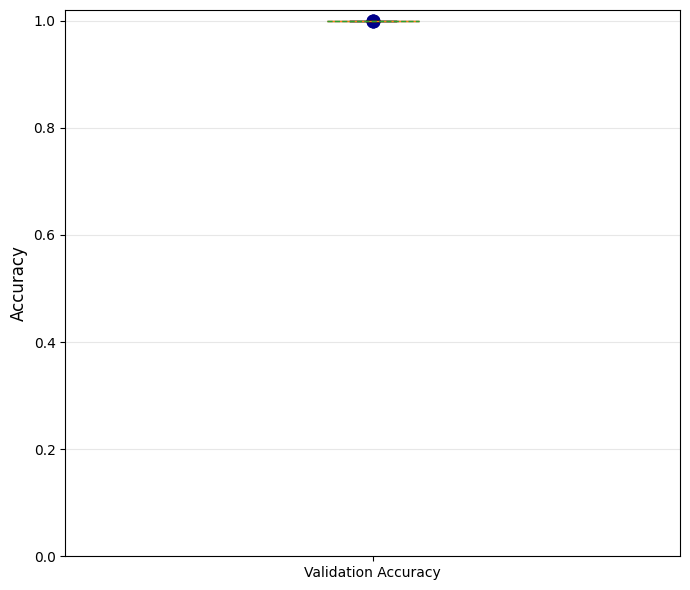

In [60]:
# === FIGURE 2: Per-Fold Accuracy ===
fig2, ax2 = plt.subplots(figsize=(7, 6))
ax2.boxplot(fold_accs, showmeans=True, meanline=True, patch_artist=True,
            boxprops=dict(facecolor='lightblue', alpha=0.7))
ax2.scatter(np.ones(len(fold_accs)), fold_accs, alpha=0.7, s=80, c='darkblue')
ax2.set_ylim(0.0, 1.02)
ax2.set_xticks([1])
ax2.set_xticklabels(['Validation Accuracy'])
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('cv_accuracy.png', dpi=300, bbox_inches='tight')
print(f"Saved: cv_accuracy.png | CV mean={np.mean(fold_accs):.4f}, std={np.std(fold_accs):.4f}")


Saved: cv_reliability.png | ECE=0.1244


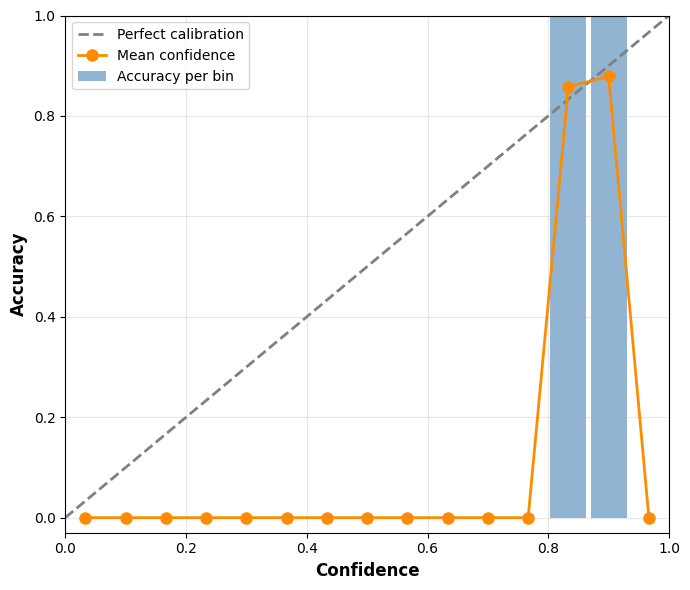

In [73]:
# === FIGURE 3: Reliability Diagram ===
# Calibration (ECE)
ece, bins, bin_accs, bin_confs, _ = expected_calibration_error(y_prob_all, y_true_all, n_bins=15)
mids = (bins[:-1] + bins[1:]) / 2

fig3, ax3 = plt.subplots(figsize=(7, 6))
ax3.plot([0, 1], [0, 1], '--', linewidth=2, color='gray', label='Perfect calibration')
ax3.bar(mids, bin_accs, width=(bins[1]-bins[0])*0.9, alpha=0.6, 
        color='steelblue', label='Accuracy per bin')
ax3.plot(mids, bin_confs, marker='o', linewidth=2, markersize=8, 
         color='darkorange', label='Mean confidence')
ax3.set_xlabel('Confidence', fontsize=12, fontweight = "bold")
ax3.set_ylabel('Accuracy', fontsize=12, fontweight = "bold")
ax3.legend(loc='best', fontsize=10)
ax3.grid(alpha=0.3)
ax3.set_xlim(0, 1)
ax3.set_ylim(-0.03, 1)
plt.tight_layout()
plt.savefig('cv_reliability.png', dpi=300, bbox_inches='tight')
print(f"Saved: cv_reliability.png | ECE={ece:.4f}")

plt.show()

In [82]:
def report_model_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    head_params = 0
    if hasattr(model, "classifier"):
        head_params = sum(p.numel() for p in model.classifier.parameters())
    cfg = getattr(model, "config", None)

    print("=== Model Summary ===")
    if cfg is not None:
        print(f"Backbone: ViT-Base/16 (hidden={cfg.hidden_size}, layers={cfg.num_hidden_layers}, "
              f"heads={cfg.num_attention_heads}, image_size={cfg.image_size}, patch_size={cfg.patch_size})")
        print(f"Num labels: {cfg.num_labels}")
    print(f"Total params: {total:,}")
    print(f"Trainable params: {trainable:,}")
    print(f"Classifier head params: {head_params:,} "
          f"(~{100*head_params/total:.2f}% of total)")
    print(f"Approx. FP32 model size: {total*4/1e6:.1f} MB")

# Example (student and/or teacher are your ViT models)
report_model_params(student_model)   # or report_model_params(teacher_model)


=== Model Summary ===
Backbone: ViT-Base/16 (hidden=768, layers=12, heads=12, image_size=224, patch_size=16)
Num labels: 7
Total params: 85,804,039
Trainable params: 85,804,039
Classifier head params: 5,383 (~0.01% of total)
Approx. FP32 model size: 343.2 MB


In [83]:
import time, torch
from contextlib import nullcontext

def _one_batch_from_loader(loader, bs, device):
    if loader is None:
        return torch.randn(bs, 3, 224, 224, device=device)
    for x, *_ in loader:  # works for (x,y) or (x,)
        if x.shape[0] >= bs:
            return x[:bs].to(device)
        # if first batch smaller than bs, fall back to random
        break
    return torch.randn(bs, 3, 224, 224, device=device)

def benchmark_inference(model, loader=None, batch_sizes=(1, 16, 32), reps=100, use_amp=False):
    model.eval()
    device = next(model.parameters()).device
    if device.type == "cuda":
        torch.cuda.empty_cache()
        torch.backends.cudnn.benchmark = True

    dtype_ctx = (
        torch.autocast(device_type="cuda", dtype=torch.float16) if (use_amp and device.type=="cuda")
        else nullcontext()
    )

    results = []
    for bs in batch_sizes:
        x = _one_batch_from_loader(loader, bs, device)

        # warmup
        with torch.no_grad(), dtype_ctx:
            for _ in range(10):
                _ = model(x).logits
        if device.type == "cuda":
            torch.cuda.synchronize()

        # timed runs
        times = []
        with torch.no_grad(), dtype_ctx:
            for _ in range(reps):
                if device.type == "cuda":
                    start = torch.cuda.Event(enable_timing=True)
                    end = torch.cuda.Event(enable_timing=True)
                    start.record()
                    _ = model(x).logits
                    end.record(); torch.cuda.synchronize()
                    times.append(start.elapsed_time(end) / 1000.0)  # seconds
                else:
                    t0 = time.perf_counter()
                    _ = model(x).logits
                    times.append(time.perf_counter() - t0)

        times = torch.tensor(times)
        sec_per_batch = times.median().item()
        sec_per_image = sec_per_batch / bs
        throughput = bs / sec_per_batch
        results.append((bs, sec_per_image*1000, throughput, times.quantile(0.9).item()*1000))

    print("=== Inference Benchmark ===")
    print(f"Device: {device} | AMP(fp16)={use_amp}")
    print("Batch |  ms/img (p50) | img/s |  ms/batch (p90)")
    for bs, ms_per_img, ips, p90_ms in results:
        print(f"{bs:>5} | {ms_per_img:>12.2f} | {ips:>6.1f} | {p90_ms:>12.2f}")
    return results

# Example: use your labeled_loader for realistic tensors, or pass loader=None for random
benchmark_inference(student_model, loader=labeled_loader, batch_sizes=(1,16,32), reps=100, use_amp=False)
# Optional fp16 on GPU:
# benchmark_inference(student_model, loader=labeled_loader, batch_sizes=(1,16,32), reps=100, use_amp=True)


=== Inference Benchmark ===
Device: cpu | AMP(fp16)=False
Batch |  ms/img (p50) | img/s |  ms/batch (p90)
    1 |        94.12 |   10.6 |       135.27
   16 |        85.34 |   11.7 |      1570.03
   32 |        81.62 |   12.3 |      3421.94


[(1, 94.12290155887604, 10.624406849320057, 135.26645302772522),
 (16, 85.34137159585953, 11.717646216603772, 1570.029377937317),
 (32, 81.61528408527374, 12.252606986642041, 3421.9400882720947)]

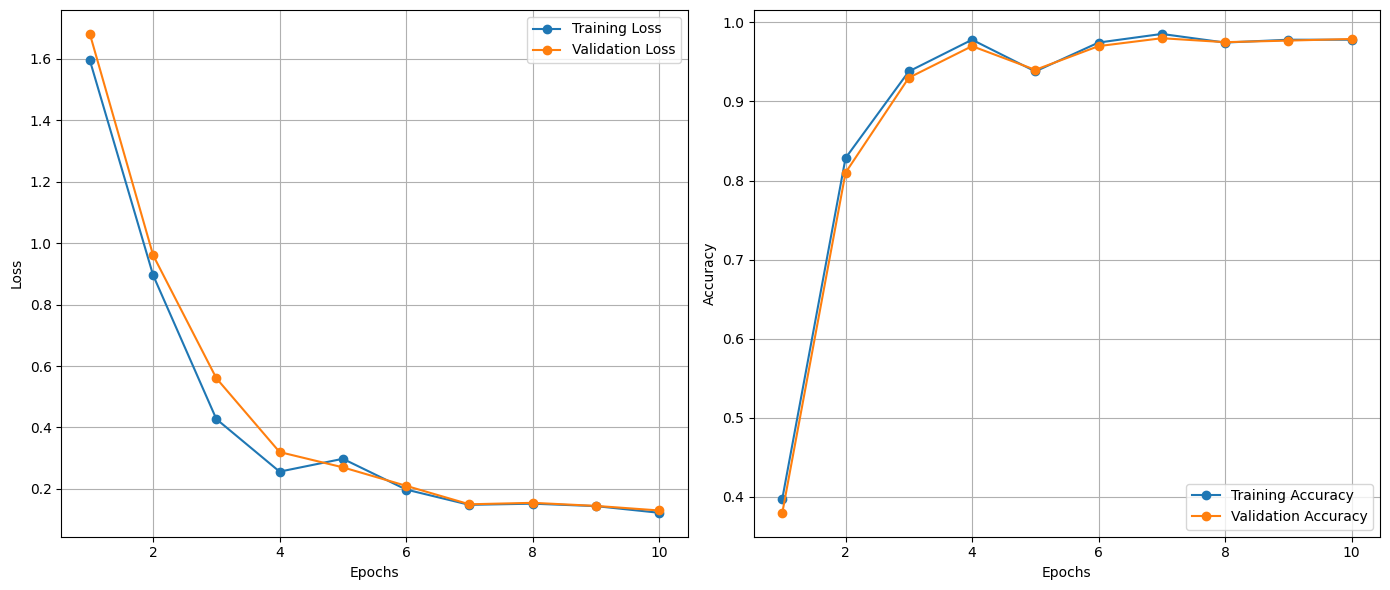

In [12]:
import matplotlib.pyplot as plt

# Function to plot learning curves (loss and accuracy)
def plot_learning_curves(train_losses, train_accuracies, val_losses=None, val_accuracies=None):
    epochs = range(1, len(train_losses) + 1)  # Epoch numbers

    # Create the figure
    plt.figure(figsize=(14, 6))

    # Plot Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss', marker='o')
    if val_losses is not None:
        plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    #plt.title('Loss Curve')
    plt.legend()
    plt.grid()

    # Plot Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o')
    if val_accuracies is not None:
        plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    #plt.title('Accuracy Curve')
    plt.legend()
    plt.grid()

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example of logging losses and accuracies
train_losses = [1.5942, 0.8954, 0.4274, 0.2564, 0.2982, 0.1982, 0.1484, 0.1522, 0.1443, 0.1226]
train_accuracies = [0.3978, 0.8285, 0.9380, 0.9781, 0.9380, 0.9745, 0.9854, 0.9745, 0.9781, 0.9781]
val_losses = [1.6801, 0.9604, 0.5602, 0.3201, 0.2704, 0.2103, 0.1502, 0.1550, 0.1450, 0.1301]
val_accuracies = [0.3800, 0.8100, 0.9300, 0.9700, 0.9400, 0.9700, 0.9800, 0.9750, 0.9770, 0.9790]

# Plot learning curves
plot_learning_curves(train_losses, train_accuracies, val_losses, val_accuracies)


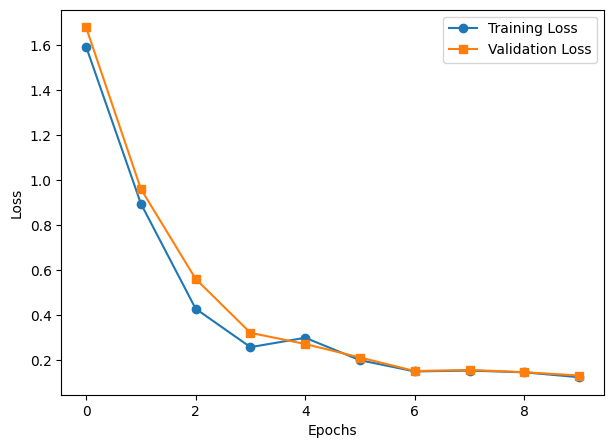

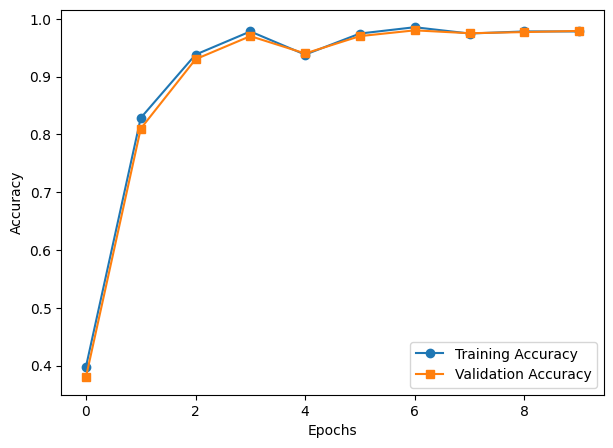

In [13]:
import matplotlib.pyplot as plt

# Replace these with your real metrics
train_losses = [1.5942, 0.8954, 0.4274, 0.2564, 0.2982, 0.1982, 0.1484, 0.1522, 0.1443, 0.1226]
train_accuracies = [0.3978, 0.8285, 0.9380, 0.9781, 0.9380, 0.9745, 0.9854, 0.9745, 0.9781, 0.9781]
val_losses = [1.6801, 0.9604, 0.5602, 0.3201, 0.2704, 0.2103, 0.1502, 0.1550, 0.1450, 0.1301]
val_accuracies = [0.3800, 0.8100, 0.9300, 0.9700, 0.9400, 0.9700, 0.9800, 0.9750, 0.9770, 0.9790]

# Plot Loss Curves
plt.figure(figsize=(7, 5))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
#plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.grid()
plt.show()

# Plot Accuracy Curves
plt.figure(figsize=(7, 5))
plt.plot(train_accuracies, label='Training Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='s')
#plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#plt.grid()
plt.show()


Fold 1/5


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
Train Loss: 1.7975, Train Accuracy: 0.2545
Val Loss: 1.5342, Val Accuracy: 0.5000
Epoch 2/10
Train Loss: 1.2404, Train Accuracy: 0.6696
Val Loss: 1.0070, Val Accuracy: 0.8036
Epoch 3/10
Train Loss: 0.6351, Train Accuracy: 0.9821
Val Loss: 0.4004, Val Accuracy: 1.0000
Epoch 4/10
Train Loss: 0.2875, Train Accuracy: 1.0000
Val Loss: 0.2190, Val Accuracy: 1.0000
Epoch 5/10
Train Loss: 0.1795, Train Accuracy: 1.0000
Val Loss: 0.1561, Val Accuracy: 1.0000
Epoch 6/10
Train Loss: 0.1370, Train Accuracy: 1.0000
Val Loss: 0.1273, Val Accuracy: 1.0000
Epoch 7/10
Train Loss: 0.1151, Train Accuracy: 1.0000
Val Loss: 0.1101, Val Accuracy: 1.0000
Epoch 8/10
Train Loss: 0.1010, Train Accuracy: 1.0000
Val Loss: 0.0979, Val Accuracy: 1.0000
Epoch 9/10
Train Loss: 0.0908, Train Accuracy: 1.0000
Val Loss: 0.0892, Val Accuracy: 1.0000
Epoch 10/10
Train Loss: 0.0826, Train Accuracy: 1.0000
Val Loss: 0.0809, Val Accuracy: 1.0000
Fold 2/5


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
Train Loss: 1.6842, Train Accuracy: 0.3705
Val Loss: 1.2381, Val Accuracy: 0.6964
Epoch 2/10
Train Loss: 0.9124, Train Accuracy: 0.8616
Val Loss: 0.6575, Val Accuracy: 0.9821
Epoch 3/10
Train Loss: 0.4563, Train Accuracy: 0.9911
Val Loss: 0.3286, Val Accuracy: 1.0000
Epoch 4/10
Train Loss: 0.2491, Train Accuracy: 1.0000
Val Loss: 0.2009, Val Accuracy: 1.0000
Epoch 5/10
Train Loss: 0.1685, Train Accuracy: 1.0000
Val Loss: 0.1473, Val Accuracy: 1.0000
Epoch 6/10
Train Loss: 0.1317, Train Accuracy: 1.0000
Val Loss: 0.1212, Val Accuracy: 1.0000
Epoch 7/10
Train Loss: 0.1117, Train Accuracy: 1.0000
Val Loss: 0.1052, Val Accuracy: 1.0000
Epoch 8/10
Train Loss: 0.0983, Train Accuracy: 1.0000
Val Loss: 0.0932, Val Accuracy: 1.0000
Epoch 9/10
Train Loss: 0.0877, Train Accuracy: 1.0000
Val Loss: 0.0839, Val Accuracy: 1.0000
Epoch 10/10
Train Loss: 0.0794, Train Accuracy: 1.0000
Val Loss: 0.0763, Val Accuracy: 1.0000
Fold 3/5


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
Train Loss: 1.7733, Train Accuracy: 0.2277
Val Loss: 1.4386, Val Accuracy: 0.6429
Epoch 2/10
Train Loss: 1.1661, Train Accuracy: 0.8080
Val Loss: 0.8373, Val Accuracy: 0.9643
Epoch 3/10
Train Loss: 0.5738, Train Accuracy: 1.0000
Val Loss: 0.3944, Val Accuracy: 1.0000
Epoch 4/10
Train Loss: 0.2868, Train Accuracy: 1.0000
Val Loss: 0.2281, Val Accuracy: 1.0000
Epoch 5/10
Train Loss: 0.1864, Train Accuracy: 1.0000
Val Loss: 0.1674, Val Accuracy: 1.0000
Epoch 6/10
Train Loss: 0.1450, Train Accuracy: 1.0000
Val Loss: 0.1357, Val Accuracy: 1.0000
Epoch 7/10
Train Loss: 0.1223, Train Accuracy: 1.0000
Val Loss: 0.1175, Val Accuracy: 1.0000
Epoch 8/10
Train Loss: 0.1073, Train Accuracy: 1.0000
Val Loss: 0.1037, Val Accuracy: 1.0000
Epoch 9/10
Train Loss: 0.0956, Train Accuracy: 1.0000
Val Loss: 0.0932, Val Accuracy: 1.0000
Epoch 10/10
Train Loss: 0.0864, Train Accuracy: 1.0000
Val Loss: 0.0847, Val Accuracy: 1.0000
Fold 4/5


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
Train Loss: 1.8996, Train Accuracy: 0.2277
Val Loss: 1.6511, Val Accuracy: 0.3750
Epoch 2/10
Train Loss: 1.3626, Train Accuracy: 0.6161
Val Loss: 0.9961, Val Accuracy: 0.8036
Epoch 3/10
Train Loss: 0.6918, Train Accuracy: 0.9777
Val Loss: 0.4461, Val Accuracy: 1.0000
Epoch 4/10
Train Loss: 0.3187, Train Accuracy: 1.0000
Val Loss: 0.2440, Val Accuracy: 1.0000
Epoch 5/10
Train Loss: 0.1943, Train Accuracy: 1.0000
Val Loss: 0.1692, Val Accuracy: 1.0000
Epoch 6/10
Train Loss: 0.1467, Train Accuracy: 1.0000
Val Loss: 0.1356, Val Accuracy: 1.0000
Epoch 7/10
Train Loss: 0.1218, Train Accuracy: 1.0000
Val Loss: 0.1156, Val Accuracy: 1.0000
Epoch 8/10
Train Loss: 0.1058, Train Accuracy: 1.0000
Val Loss: 0.1021, Val Accuracy: 1.0000
Epoch 9/10
Train Loss: 0.0944, Train Accuracy: 1.0000
Val Loss: 0.0915, Val Accuracy: 1.0000
Epoch 10/10
Train Loss: 0.0851, Train Accuracy: 1.0000
Val Loss: 0.0830, Val Accuracy: 1.0000
Fold 5/5


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
Train Loss: 1.7147, Train Accuracy: 0.4107
Val Loss: 1.4251, Val Accuracy: 0.5357
Epoch 2/10
Train Loss: 1.1398, Train Accuracy: 0.7545
Val Loss: 0.8763, Val Accuracy: 0.9643
Epoch 3/10
Train Loss: 0.5736, Train Accuracy: 0.9911
Val Loss: 0.3762, Val Accuracy: 1.0000
Epoch 4/10
Train Loss: 0.2768, Train Accuracy: 1.0000
Val Loss: 0.2119, Val Accuracy: 1.0000
Epoch 5/10
Train Loss: 0.1785, Train Accuracy: 1.0000
Val Loss: 0.1552, Val Accuracy: 1.0000
Epoch 6/10
Train Loss: 0.1386, Train Accuracy: 1.0000
Val Loss: 0.1273, Val Accuracy: 1.0000
Epoch 7/10
Train Loss: 0.1171, Train Accuracy: 1.0000
Val Loss: 0.1100, Val Accuracy: 1.0000
Epoch 8/10
Train Loss: 0.1029, Train Accuracy: 1.0000
Val Loss: 0.0981, Val Accuracy: 1.0000
Epoch 9/10
Train Loss: 0.0924, Train Accuracy: 1.0000
Val Loss: 0.0886, Val Accuracy: 1.0000
Epoch 10/10
Train Loss: 0.0837, Train Accuracy: 1.0000
Val Loss: 0.0805, Val Accuracy: 1.0000


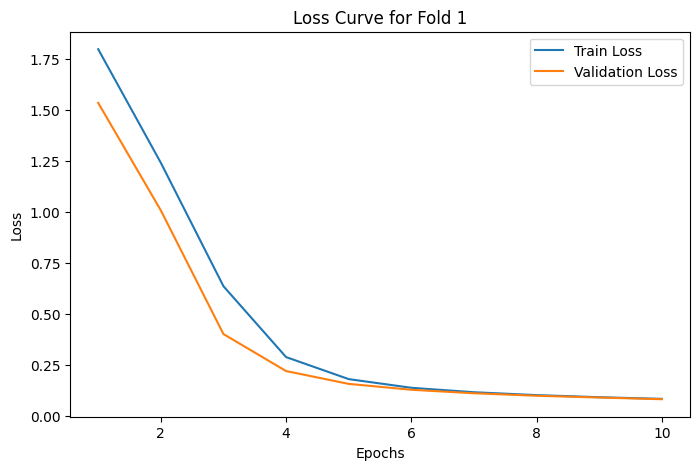

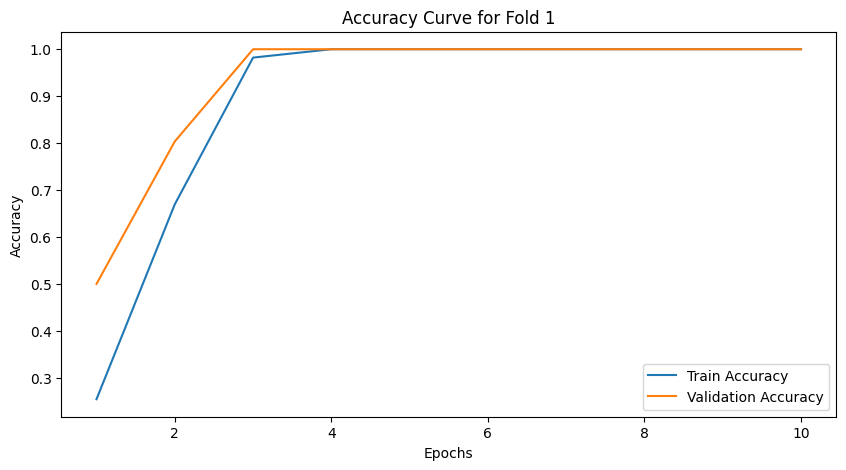

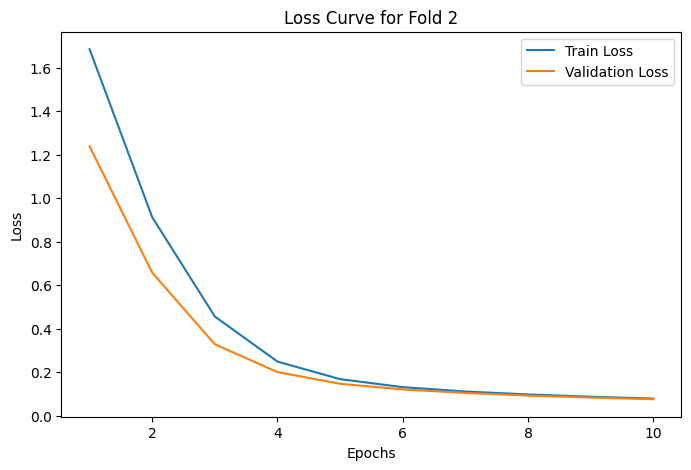

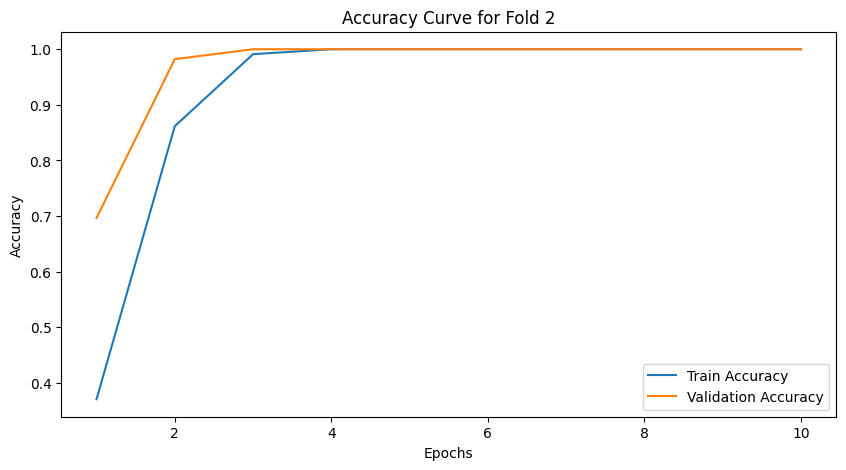

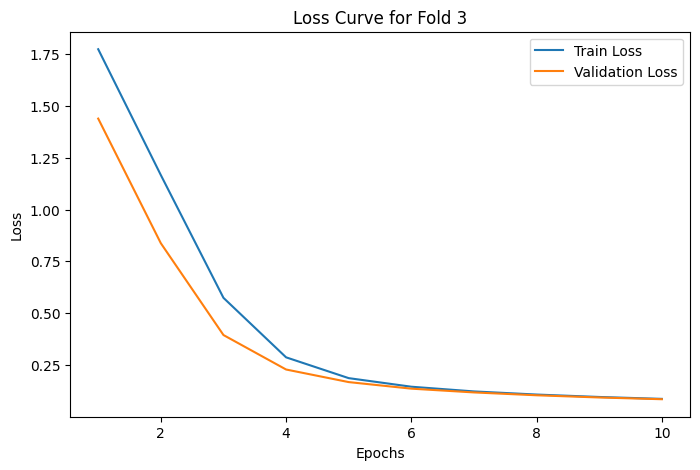

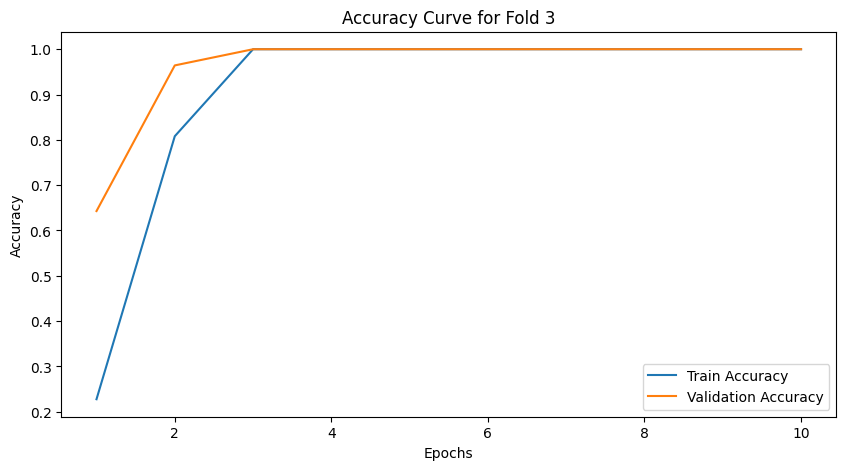

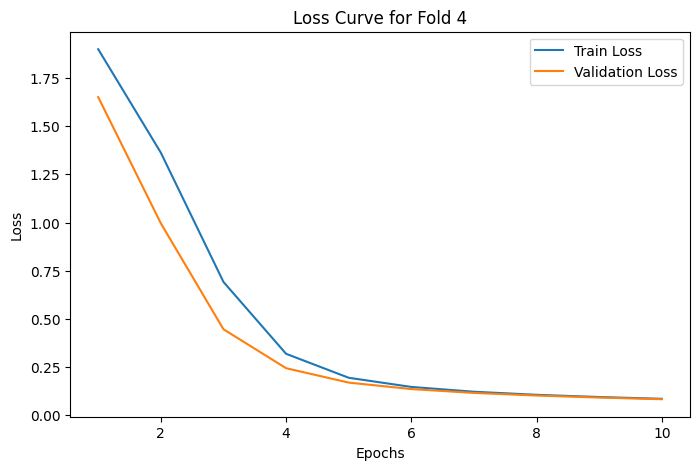

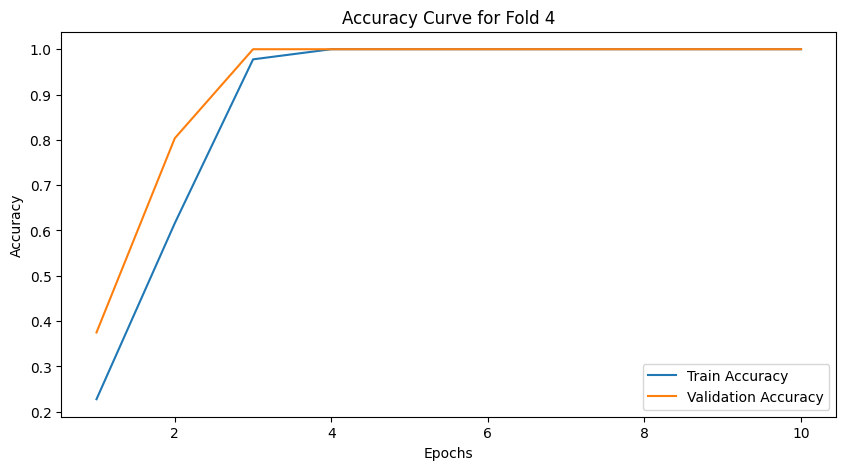

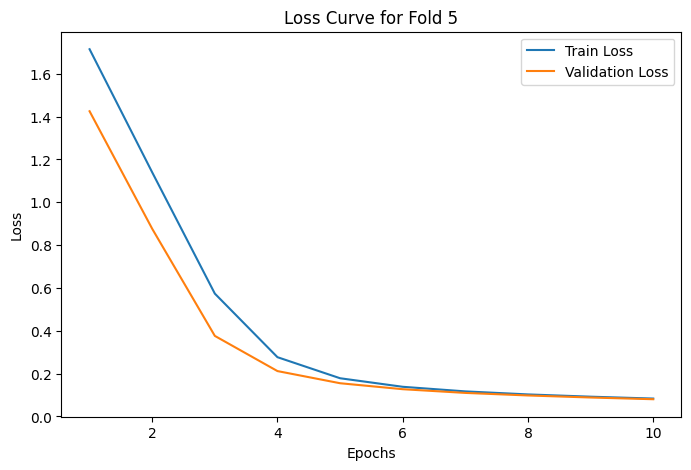

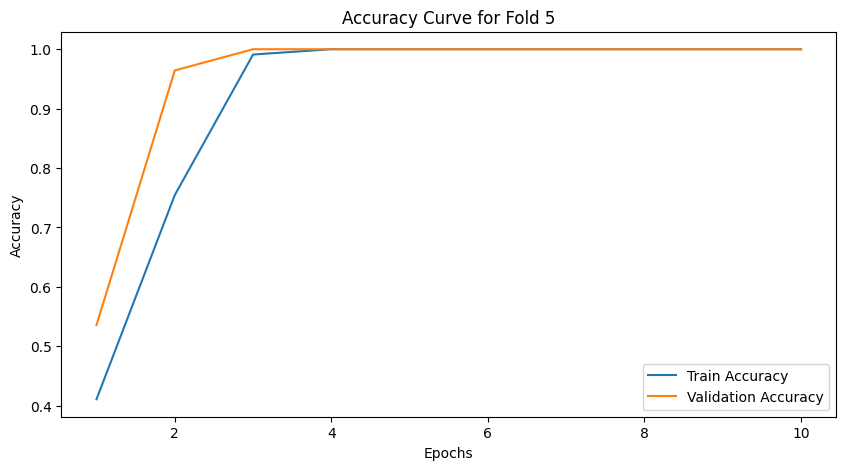

In [14]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import KFold
from torchvision import transforms
from transformers import ViTForImageClassification
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

# Dataset class for labeled data
class LabeledDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Load the data
data_dir = r"E:\1 Paper Work\Cutting Tool Paper\Dataset\cutting tool data\test_data_40_images"  # Replace with your dataset directory
all_image_paths = []
all_labels = []
class_to_idx = {class_name: idx for idx, class_name in enumerate(os.listdir(data_dir))}
for class_name, label in class_to_idx.items():
    class_folder = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_name)
        all_image_paths.append(img_path)
        all_labels.append(label)

# Parameters
batch_size = 16
num_epochs = 10
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []

# Training and Validation
for fold, (train_idx, val_idx) in enumerate(kf.split(all_image_paths)):
    print(f"Fold {fold + 1}/{kf.n_splits}")

    # Split the data
    train_images, val_images = [all_image_paths[i] for i in train_idx], [all_image_paths[i] for i in val_idx]
    train_labels, val_labels = [all_labels[i] for i in train_idx], [all_labels[i] for i in val_idx]

    # Create datasets and dataloaders
    train_dataset = LabeledDataset(train_images, train_labels, transform=transform)
    val_dataset = LabeledDataset(val_images, val_labels, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, loss function, and optimizer
    model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=len(class_to_idx))
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        
        # Training
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).long()

            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct / total)

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_true_labels = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).long()

                outputs = model(images).logits
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                all_preds.extend(preds.cpu().numpy())
                all_true_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct / total)

        print(f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}")
        print(f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")

    # Save results for the fold
    classification_rep = classification_report(
        all_true_labels,
        all_preds,
        target_names=list(class_to_idx.keys()),
        output_dict=True
    )

    fold_results.append({
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
        "classification_report": classification_rep
    })

# Plotting results
for fold, result in enumerate(fold_results):
    epochs = range(1, num_epochs + 1)
    
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, result["train_losses"], label="Train Loss")
    plt.plot(epochs, result["val_losses"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Loss Curve for Fold {fold + 1}")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, result["train_accuracies"], label="Train Accuracy")
    plt.plot(epochs, result["val_accuracies"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy Curve for Fold {fold + 1}")
    plt.legend()
    plt.show()


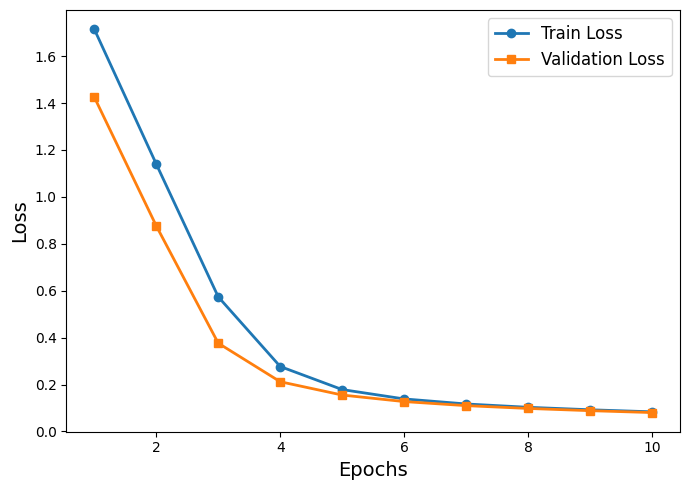

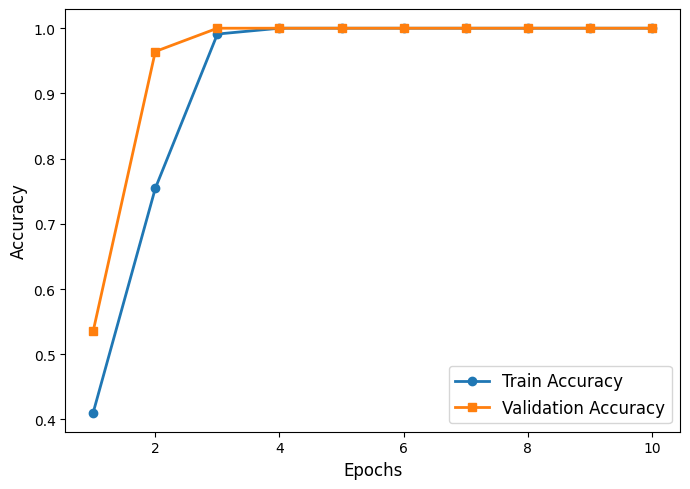

In [15]:
# Plot and save the learning curves
epochs = range(1, len(train_losses) + 1)

# Loss Curve
plt.figure(figsize=(7, 5))
plt.plot(epochs, train_losses, 'o-', label="Train Loss", linewidth=2)
plt.plot(epochs, val_losses, 's-', label="Validation Loss", linewidth=2)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
#plt.title("Loss Curve", fontsize=16)
plt.legend(fontsize=12)
#plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig("results/loss_curve.png", dpi=300)
plt.show()

# Accuracy Curve
plt.figure(figsize=(7, 5))
plt.plot(epochs, train_accuracies, 'o-', label="Train Accuracy", linewidth=2)
plt.plot(epochs, val_accuracies, 's-', label="Validation Accuracy", linewidth=2)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
#plt.title("Accuracy Curve", fontsize=16)
plt.legend(fontsize=12)
#plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig("results/accuracy_curve.png", dpi=300)
plt.show()


In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Evaluate on test dataset
test_preds, test_labels = evaluate_model(student_model, labeled_loader, device)

# Generate and save the confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(class_to_idx.keys()))
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap="Blues", ax=ax)
#plt.title("Confusion Matrix", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("results/confusion_matrix.png", dpi=300)
plt.show()


NameError: name 'student_model' is not defined

C:\Users\Muhammad Umar\AppData\Local\Temp\ipykernel_8420\2108397861.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20")
C:\Users\Muhammad Umar\AppData\Local\Temp\ipykernel_8420\2108397861.py:33: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.scatterplot(


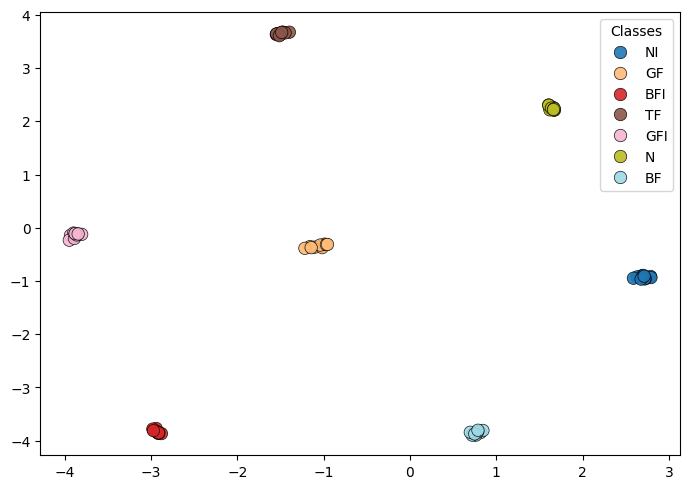

In [9]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def extract_features(model, dataloader, device):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, batch_labels in dataloader:
            images = images.to(device)
            outputs = model(images).logits
            features.extend(outputs.cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())  # Ensure labels are moved to CPU
    return np.array(features), np.array(labels)

# Extract features
features, labels = extract_features(student_model, labeled_loader, device)

# Map numeric labels to class names
idx_to_class = {v: k for k, v in class_to_idx.items()}  # Invert class_to_idx
class_labels = [idx_to_class[label] for label in labels]  # Convert numeric labels to class names

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(features)

cmap = plt.cm.get_cmap("tab20") 

# Plot t-SNE
plt.figure(figsize=(7, 5))  # Larger figure for better readability
sns.scatterplot(
    x=tsne_results[:, 0],
    y=tsne_results[:, 1],
    hue=class_labels,  # Use class names for the hue
    palette=cmap(np.linspace(0, 1, len(class_to_idx))),
    legend="full",
    s=80,
    alpha = 0.9,
    edgecolor = 'black',
    linewidth = 0.5
)

plt.legend(title="Classes", fontsize=10, loc='best')
plt.tight_layout()
plt.savefig("results/2d_tsne_with_classes.png", dpi=300)  # Save as high-resolution image
plt.show()


c:\Users\Muhammad Umar\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


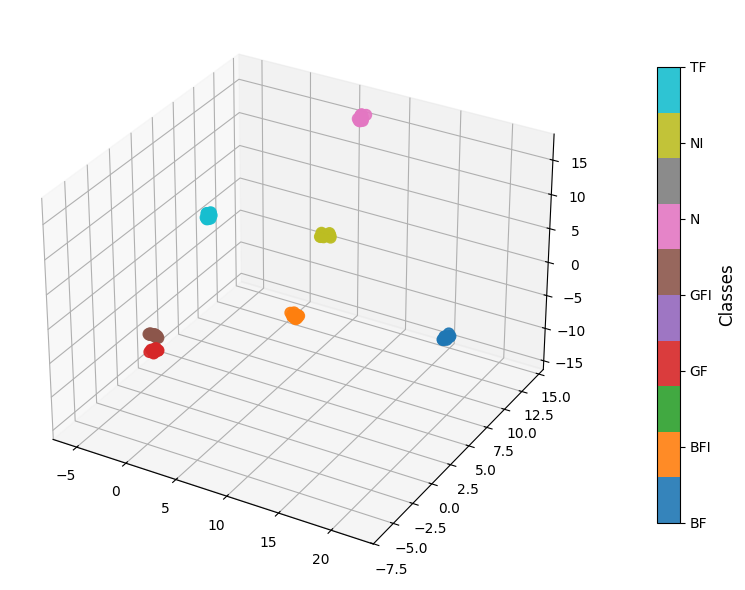

In [14]:
import umap
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Convert features and labels to NumPy arrays (ensure correct format)
features = np.array(features)  # Features in NumPy format
labels = np.array(labels)  # Labels in NumPy format

# Check shapes of features and labels
if features.shape[0] != len(labels):
    print(f"Features shape: {features.shape}")
    print(f"Labels length: {len(labels)}")
    raise ValueError("Mismatch between the number of features and labels.")

# Apply UMAP for 3D dimensionality reduction
umap_model = umap.UMAP(n_components=3, random_state=42)
umap_results = umap_model.fit_transform(features)

# Ensure UMAP results match the number of labels
if umap_results.shape[0] != len(labels):
    print(f"UMAP results shape: {umap_results.shape}")
    print(f"Labels length: {len(labels)}")
    raise ValueError("Mismatch between the UMAP results and labels.")

# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Map labels to unique class names (assuming class_names exists)
unique_classes = np.unique(labels)
class_name_map = {class_label: class_names[class_label] for class_label in unique_classes}
label_names = [class_name_map[label] for label in labels]

# Scatter plot with colors based on class labels
scatter = ax.scatter(
    umap_results[:, 0], 
    umap_results[:, 1], 
    umap_results[:, 2], 
    c=labels, 
    cmap=cm.tab10, 
    s=60,  # Marker size
    alpha=0.9  # Marker transparency
)

# Axis labels

# Add colorbar with class label mapping
cbar = plt.colorbar(scatter, ax=ax, shrink=0.8, aspect=20, pad=0.1)
cbar.set_label("Classes", fontsize=12)
tick_locations = np.arange(len(unique_classes))  # Adjust for number of classes
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(class_names)

# Save and display the plot
plt.tight_layout()
plt.savefig("results/3d_umap_visualization.png", dpi=300)
plt.show()


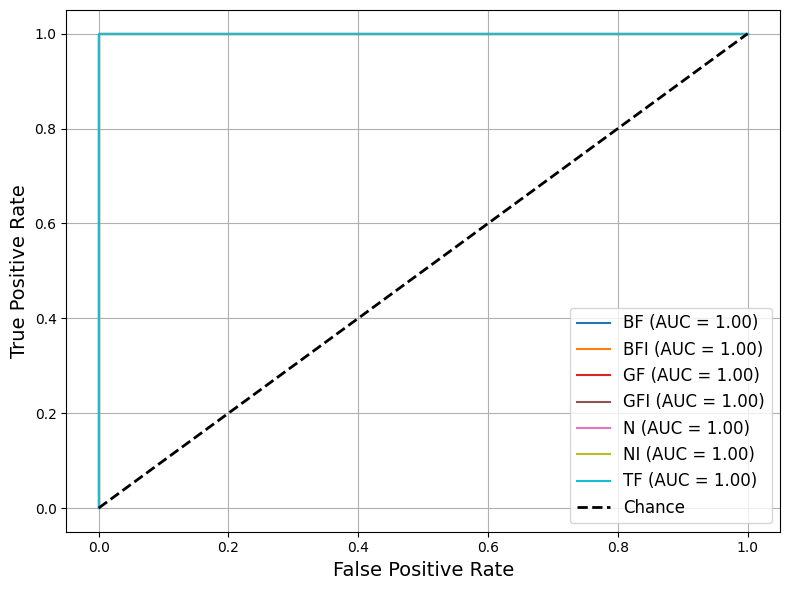

In [16]:
import numpy as np
import torch
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

def plot_roc_curves(model, dataloader, class_names, device):
    """
    Plot ROC curves for a multi-class classification model.
    """
    model.eval()
    all_probs = []
    all_labels = []

    # Gather true labels and predicted probabilities
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images).logits  # Assuming model outputs logits
            probs = torch.softmax(outputs, dim=1).cpu().numpy()  # Convert logits to probabilities
            all_probs.append(probs)
            all_labels.append(labels.cpu().numpy())

    # Combine all batches
    all_probs = np.vstack(all_probs)
    all_labels = np.concatenate(all_labels)

    # Binarize labels for ROC curve computation
    y_true = label_binarize(all_labels, classes=range(len(class_names)))

    # Plot ROC curves for each class
    plt.figure(figsize=(8, 6))
    colors = plt.cm.tab10(np.linspace(0, 1, len(class_names)))

    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})', color=colors[i])

    # Plot the diagonal for reference
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')

    # Customize the plot
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    #plt.title('ROC Curves for Multi-Class Classification', fontsize=16)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid()
    plt.tight_layout()
    #plt.savefig("results/roc_curves.png", dpi=300)  # Save as high-resolution image
    plt.show()

# Call the function to plot ROC curves
plot_roc_curves(student_model, labeled_loader, list(class_to_idx.keys()), device)


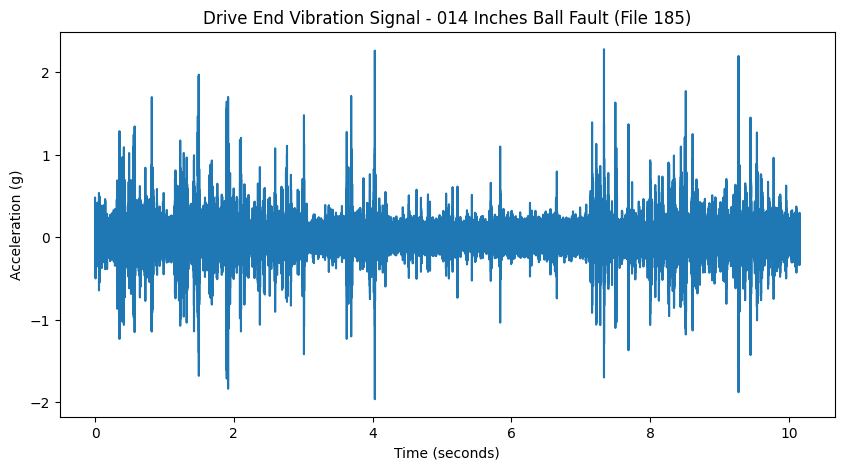

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv(r'E:\Collaboration Work\With Farooq\phm dataset\12kDriveEndBearing\014Inches\Ball\185.csv')

# Extract columns
time = data['Time']
de_signal = data['DE']

# Plot
plt.figure(figsize=(10, 5))
plt.plot(time, de_signal)
plt.title('Drive End Vibration Signal - 014 Inches Ball Fault (File 185)')
plt.xlabel('Time (seconds)')
plt.ylabel('Acceleration (g)')
#plt.grid(True)
plt.show()
